# Предсказание оттока

## Описание проекта

### Задача проекта

Оператор связи «ТелеДом» с целью предотвращения оттока клиентов планирует предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» требуется модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача проекта — обучить на указанных данных модель для прогноза оттока клиентов.

### Описание услуг

Оператор предоставляет два основных типа услуг:
- стационарная телефонная связь. Телефон можно подключить к нескольким линиям одновременно,
- интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).  

Также абонентам доступен ряд дополнительных услуг:
- интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- выделенная линия технической поддержки (Tech Support);
- облачное хранилище файлов для резервного копирования данных (Online Backup);
- стриминговое телевидение (Streaming TV);
- каталог фильмов (Streaming Movies).  

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

### Описание данных

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
- `contract` — информация о договорах;
- `personal` — персональные данные клиентов;
- `internet` — информация об интернет-услугах;
- `phone` — информация об услугах телефонии.  

Таблица `telecom.contract` содержит данные:
- `customerID` — ID абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.  

Таблица 'telecom.personal' содержит данные:
- `customerID` — ID пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.  

Таблица `telecom.internet` содержит данные:
- `customerID` — ID пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.  

Таблица `telecom.phone` содержит данные:
- `customerID` — ID пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.  

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
pip install catboost

In [2]:
pip install phik

In [3]:
pip install skorch

In [4]:
# Будем решать задачу классификации, импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import phik
from phik.report import plot_correlation_matrix

# Очистка оперативной памяти
import gc

# Нейронные сети
import torch
import torch.nn as nn
import skorch
from skorch.classifier import NeuralNetBinaryClassifier

# Модели на основе градиентного бустинга
from catboost import (CatBoostClassifier, cv as cb_cv, Pool)
from catboost.utils import get_roc_curve, select_threshold
from lightgbm import (LGBMClassifier, cv as lgbm_cv, plot_importance)

# Не будем ограничиваться нейронными сетями и градиентным бустингом.
# Попробуем более модель на основе случайного леса
from sklearn.ensemble import RandomForestClassifier

# Константная модель
from sklearn.dummy import DummyClassifier

# Разделение выборок, подбор гиперпараметров
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.metrics import (
    accuracy_score, # Расчёт accuracy
    roc_auc_score,  # Расчёт AUC ROC
    roc_curve,  # Построение ROC-кривой
    confusion_matrix  # Вычисление tn, fp, fn, tp
)

# Масштабирование и кодирования признаков
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder, OrdinalEncoder)

TABLES = {
    'telecom.contract': '(информация о договорах)',
    'telecom.personal': '(персональные данные клиентов)',
    'telecom.internet': '(информация об интернет-услугах)',
    'telecom.phone': '(информация об услугах телефонии)'
}
RANDOM_STATE = 20231212

## Анализ данных в таблицах

### Подключение к базе. Загрузка таблиц sql

In [5]:
# Конфигурация для подключения к базе данных
db_config = {
    'user': 'praktikum_student',  # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp',  # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,  # порт подключения
    'db': 'data-science-final',  # название базы данных
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [6]:
# Подключимся к базе данных
engine = create_engine(connection_string)

### Проверка ключей и наличия записей

In [7]:
# Рассмотрим первые строки таблиц
for table in TABLES.keys():
    query = (
        '''
    SELECT *
    FROM '''
        + table
        + ' LIMIT 5'
    )
    print(f'Таблица {table} {TABLES[table]}')
    print()
    try:
        print(pd.read_sql_query(query, con=engine))
    except:
        conn = engine.connect()
        print(pd.DataFrame(conn.execute(text(query))))
        conn.close()
    print()

Таблица telecom.contract (информация о договорах)

   customerID   BeginDate     EndDate            Type PaperlessBilling  \
0  4472-LVYGI  2020-02-01        None        Two year              Yes   
1  3115-CZMZD  2020-02-01        None        Two year               No   
2  3668-QPYBK  2018-08-09  2019-12-01  Month-to-month              Yes   
3  5709-LVOEQ  2020-02-01        None        Two year               No   
4  9237-HQITU  2019-01-26  2019-11-01  Month-to-month              Yes   

               PaymentMethod MonthlyCharges TotalCharges  
0  Bank transfer (automatic)          52.55         None  
1               Mailed check          20.25         None  
2               Mailed check          53.85       108.15  
3               Mailed check          80.85         None  
4           Electronic check           70.7       151.65  

Таблица telecom.personal (персональные данные клиентов)

   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0

Все колонки в таблицах соответствуют схеме базы данных. Убедимся в том, что customerID является ключом для связи таблиц.

In [8]:
# Посмотрим количество записей в таблицах
print('Количество записей в таблицах:')
for table in TABLES.keys():
    query = (
        '''
    SELECT COUNT(*)
    FROM '''
        + table
    )
    try:
        print(
            f'{table} {TABLES[table]} {pd.read_sql_query(query, con=engine).values.flatten()[0]}'
        )
    except:
        conn = engine.connect()
        print(
            f'{table} {TABLES[table]} {pd.DataFrame(conn.execute(text(query))).values.flatten()[0]}'
        )
        conn.close()

Количество записей в таблицах:
telecom.contract (информация о договорах) 7043
telecom.personal (персональные данные клиентов) 7043
telecom.internet (информация об интернет-услугах) 5518
telecom.phone (информация об услугах телефонии) 6362


Если поле `customerID` является ключом для связи всех таблиц, то должны выполняться условия:
1. количество записей в результате объединения оператором INNER JOIN таблиц `telecom.contract`, `telecom.personal` по ключу `customerID` должно составить 7043 при выборе уникальных значений `customerID`, т.к. обе таблицы содержат информацию обо всех клиентах. При этом значения `customerID` должны быть уникальными,
2. количество записей в результате объединения оператором FULL JOIN таблиц `telecom.internet` и `telecom.phone` по ключу `customerID` должно составить 7043, т.к. таблицы содержат информацию об услугах, которыми пользуются все клиенты,
3. количество записей в результате объединения оператором INNER JOIN таблиц `telecom.personal` и `telecom.internet` по ключу `customerID` должно составлять 5517 (так как услуги интернета подключены у 5517 пользователей),
4. количество записей в результате объединения оператором INNER JOIN таблиц `telecom.personal` и `telecom.phone` по ключу `customerID` должно составлять 6361 (так как услуги интернета подключены у 6361 пользователей).

In [9]:
# Проверим первое условие
query = '''
SELECT COUNT(DISTINCT c."customerID")
FROM telecom.contract AS c
INNER JOIN telecom.personal AS p ON c."customerID" = p."customerID"
'''
try:
    print(
        'Количество строк с уникальными customerID',
        pd.read_sql_query(query, con=engine).values.flatten()[0],
    )
except:
    conn = engine.connect()
    print(
        'Количество строк с уникальными customerID',
        pd.DataFrame(conn.execute(text(query))).values.flatten()[0],
    )
    conn.close()

query = '''
SELECT COUNT(*)
FROM telecom.contract AS c
INNER JOIN telecom.personal AS p ON c."customerID" = p."customerID"
'''
try:
    print(
        'Количество строк со всеми customerID',
        pd.read_sql_query(query, con=engine).values.flatten()[0],
    )
except:
    conn = engine.connect()
    print(
        'Количество строк со всеми customerID',
        pd.DataFrame(conn.execute(text(query))).values.flatten()[0],
    )
    conn.close()


Количество строк с уникальными customerID 7043
Количество строк со всеми customerID 7043


Первое условие выполнено: в таблицах `telecom.contract`, `telecom.personal` значения ключей совпадают и являются уникальными.

In [10]:
# Проверим второе условие
query = '''
      SELECT COUNT(*)
      FROM (SELECT c1 AS id
            FROM telecom.internet
            WHERE c1 <> 'customerID') AS int
      FULL JOIN (SELECT c1 AS id
                 FROM telecom.phone
                 WHERE c1 <> 'customerID') AS ph
      ON int.id = ph.id
'''

try:
    print(
        'Количество строк после объединения',
        pd.read_sql_query(query, con=engine).values.flatten()[0],
    )
except:
    conn = engine.connect()
    print(
        'Количество строк после объединения',
        pd.DataFrame(conn.execute(text(query))).values.flatten()[0],
    )
    conn.close()

Количество строк после объединения 7043


Второе условие выполнено: в объединённых таблицах с даннымии о подключенных услугах количество ключей совпадает с количеством ключей в таблицах с данными пользователей.

In [11]:
# Проверим третье условие
query = '''
      SELECT COUNT(*)
      FROM (SELECT c1 AS id
            FROM telecom.internet) AS int
      INNER JOIN (SELECT 'customerID' AS id
                 FROM telecom.personal) AS p
      ON int.id = p.id
'''

try:
    print(
        'Количество строк после объединения',
        pd.read_sql_query(query, con=engine).values.flatten()[0],
    )
except:
    conn = engine.connect()
    print(
        'Количество строк после объединения',
        pd.DataFrame(conn.execute(text(query))).values.flatten()[0],
    )
    conn.close()

Количество строк после объединения 7043


In [12]:
# Проверим четвёртое условие
query = '''
      SELECT COUNT(*)
      FROM (SELECT c1 AS id
            FROM telecom.phone) AS ph
      INNER JOIN (SELECT 'customerID' AS id
                 FROM telecom.personal) AS p
      ON ph.id = p.id
'''

try:
    print(
        'Количество строк после объединения',
        pd.read_sql_query(query, con=engine).values.flatten()[0],
    )
except:
    conn = engine.connect()
    print(
        'Количество строк после объединения',
        pd.DataFrame(conn.execute(text(query))).values.flatten()[0],
    )
    conn.close()

Количество строк после объединения 7043


Третье и четвёртое условия соблюдаются: ключи в таблицах с данными об услугах соответствуют ключам в таблице с данными клиентов.

Выводы:
- таблицы и колонки в таблицах соответствуют описанию базы данных,
- имеется общий ключ `customerID` для связи таблиц,
- в таблицах имеются данные.

### Данные о договорах

In [13]:
# Так как записей 7043, можем загрузить всю таблицу в датафрейм
# Проверим четвёртое условие
query = '''
      SELECT *
      FROM telecom.contract
'''

try:
    contract_df = pd.read_sql_query(query, con=engine)
    print(contract_df.info())
except:
    conn = engine.connect()
    contract_df = pd.DataFrame(conn.execute(text(query)))
    print(contract_df.info())
    conn.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           1869 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7032 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB
None


In [14]:
# Приведём тип данных с датами к datetime
# BeginDate
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format='%Y-%m-%d')
# Определим диапазон дат начала действия договоров
try:
    print(contract_df['BeginDate'].describe(datetime_is_numeric=True))
except:
    print(contract_df['BeginDate'].describe())

count                             7043
mean     2019-03-20 03:51:02.274599168
min                2018-04-17 00:00:00
25%                2019-01-18 12:00:00
50%                2019-03-22 00:00:00
75%                2019-05-21 00:00:00
max                2020-02-01 00:00:00
Name: BeginDate, dtype: object


In [15]:
# То же и с EndDate
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], format='%Y-%m-%d')
try:
    print(contract_df['EndDate'].describe(datetime_is_numeric=True))
except:
    print(contract_df['EndDate'].describe())

count                             1869
mean     2019-11-15 21:31:18.009630720
min                2019-10-01 00:00:00
25%                2019-11-01 00:00:00
50%                2019-11-01 00:00:00
75%                2019-12-01 00:00:00
max                2020-01-01 00:00:00
Name: EndDate, dtype: object


Имеются данные о 7043 договорах, заключенных в период с 17.04.2018 г по 01.02.2020 г., 1869 из которых были закрыты в период с 01.10.2019 г по 01.01.2020 г

In [16]:
# Проверим, имеются строки с датой заключения договора более поздней, чем
# дата закрытия договора
(contract_df['EndDate'] < contract_df['BeginDate']).sum()

0

In [17]:
# Выполним когортный анализ оттока клиентов
# Обозначим месяц подключения абонента
contract_df['begin_month'] = contract_df['BeginDate'].dt.to_period('M')
# Обозначим месяц отключения абонента
contract_df['end_month'] = contract_df['EndDate'].dt.to_period('M')

In [18]:
churn = contract_df[['customerID', 'begin_month', 'end_month']].copy()
churn_group = (
     churn
    .groupby(['begin_month'])
    .agg(start=('customerID', 'count'))
)
for i in range(len(churn_group.index)):
    churn_group[str(churn_group.index[i])] = (
        churn.loc[(churn['end_month'] == churn_group.index[i])]
        .groupby(['begin_month'])['customerID']
        .agg('count')
    )
    churn_group.loc[
        churn_group.index <= churn_group.index[i], str(churn_group.index[i])
    ] = churn_group.loc[
        churn_group.index <= churn_group.index[i], str(churn_group.index[i])
    ].fillna(
        0
    )
    churn_group.loc[
        churn_group.index == churn_group.index[i], str(churn_group.index[i])
    ] = (
        churn_group['start']
        - churn_group.loc[
            churn_group.index == churn_group.index[i], str(churn_group.index[i])
        ]
    )
    if i > 0:
        churn_group.loc[
            churn_group.index < churn_group.index[i], str(churn_group.index[i])
        ] = (
            churn_group.loc[
                churn_group.index < churn_group.index[i], str(churn_group.index[i - 1])
            ]
            - churn_group.loc[
                churn_group.index < churn_group.index[i], str(churn_group.index[i])
            ]
        )
for i in range(len(churn_group.index)):
    churn_group[str(churn_group.index[i])] = (
        round(
            100*churn_group[str(churn_group.index[i])] / churn_group['start'],
            1
        )
    )
churn_group

,start,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,...,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02
begin_month,,,,,,,,,,,,,,,,,,,,,
2018-04,3,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,66.7,0.0,0.0,0.0,0.0
2018-05,6,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,16.7,0.0,0.0,0.0,0.0
2018-06,13,NaN,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,38.5,15.4,7.7,7.7,7.7
2018-07,41,NaN,NaN,NaN,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,58.5,34.1,26.8,19.5,19.5
2018-08,75,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,66.7,46.7,34.7,20.0,20.0
2018-09,131,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,71.0,48.1,36.6,27.5,27.5
2018-10,210,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,75.2,59.0,45.2,39.5,39.5
2018-11,358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,82.7,63.1,52.5,45.0,45.0
2018-12,542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,...,100.0,100.0,100.0,100.0,100.0,84.9,70.5,61.3,53.5,53.5


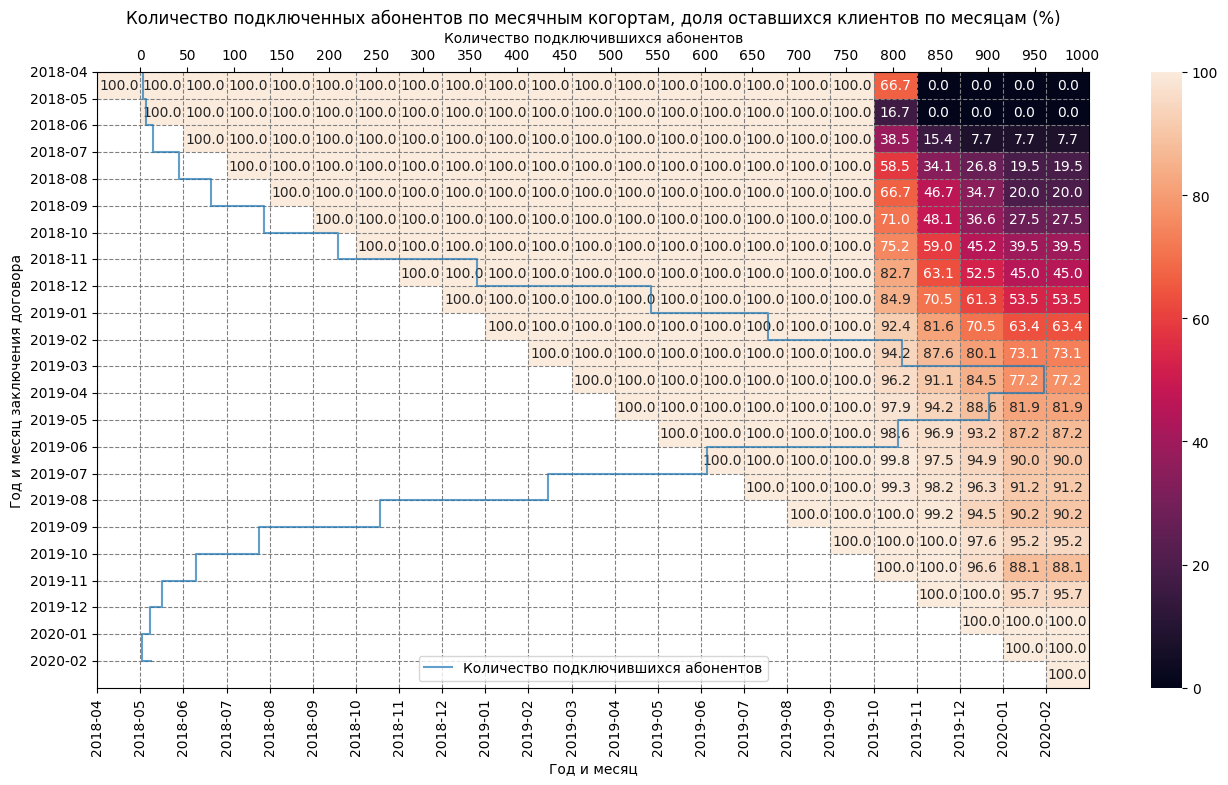

In [19]:
# Посмотрим, как подключались абоненты по времени и как уменьшалось со
# временем количество клиентов по когортам
plt.figure(figsize=(16, 8))  # задаём размер графика
ax = plt.gca()
sns.heatmap(
    churn_group.iloc[:, 1:],  # датафрейм с данными
    annot=True,  # добавляем подписи
    fmt='',
)  # задаём исходный формат
plt.title(
    'Количество подключенных абонентов по месячным когортам, доля оставшихся клиентов по месяцам (%)'
)  # название графика
plt.grid(axis='both', linestyle='--', color='grey')
ax.set_xlabel('Год и месяц')
ax.set_xticks(range(len(churn_group.index)))
ax.set_xticklabels(churn_group.index, rotation=90)
ax.set_ylabel('Год и месяц заключения договора')
ax.set_yticks(range(len(churn_group.index)))
ax.set_yticklabels(churn_group.index)
ax1 = ax.twiny()
ax1.set_xlabel('Количество подключившихся абонентов')
ax1.set_xticks(range(0, 1001, 50))
ax1.step(
    churn_group['start'],
    range(len(churn_group.index)),
    label='Количество подключившихся абонентов',
    alpha=0.7
)
plt.legend(loc='lower center')
plt.show()

Выводы:
- в период с 04.2018 г. по 03.2019 г. наблюдается рост ежемесячно подключаемых клиентов, при этом отток отсутствует,
- в период с 04.2019 г. по 02.2020 г. наблюдается снижение ежемесячно подключаемых клиентов, при этом до 10.2019 г. отток отсутствует,
- с 10.2019 г. по 01.2020 г. произошёл резкий отток клиентов, пришедших с 04.2018 г. по 03.2019 г., менее резкий отток в указанный период наблюдается и по всем остальным клиентам,
- аномалий и пропусков не наблюдается.

Поскольку наиболее сильный отток наблюдается среди клиентов, которые подключились раньше остальных, можем предположить, что где-то появились более привлекательные условия по сравнению с теми, на которых данные клиенты были подключены до 03.2019 г.

In [20]:
# Рассмотрим данные о типе оплаты
contract_df['Type'].value_counts(normalize=True, dropna=False)

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: Type, dtype: float64

Выводы:
- большинство абонентов выбрали ежемесячную оплату,
- аномалий и пропусков нет.

In [21]:
# Рассмотрим данные об электронном расчётном листе
contract_df['PaperlessBilling'].value_counts(normalize=True, dropna=False)

Yes    0.592219
No     0.407781
Name: PaperlessBilling, dtype: float64

Выводы:
- большинство абонентов предпочли расчётные листы в электронном виде,
- аномалий и пропусков нет.

In [22]:
# Рассмотрим данные о типе платежа
contract_df['PaymentMethod'].value_counts(normalize=True, dropna=False)

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: PaymentMethod, dtype: float64

Аномалий и пропусков нет.

Пропусков 0


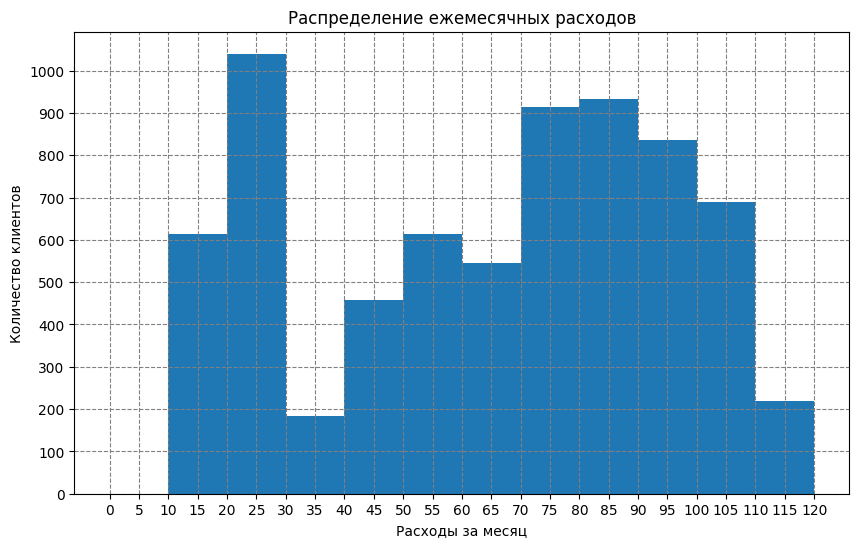

In [23]:
# Посмотрим распределение ежемесячных расходов
fig = plt.figure(figsize=(10, 6))
plt.title('Распределение ежемесячных расходов')
plt.grid(color='grey', linestyle='--')
plt.xlabel('Расходы за месяц')
plt.xticks(range(0, 121, 5))
plt.ylabel('Количество клиентов')
plt.yticks(range(0, 1601, 100))
plt.hist(contract_df['MonthlyCharges'], bins=range(0, 121, 10))
print(f'Пропусков {contract_df["MonthlyCharges"].isna().sum()}')
plt.show()

Выводы:
- наблюдается максимум в диапазоне 20-25 и 70-85,
- аномалий и пропусков нет.

Пропусков 11


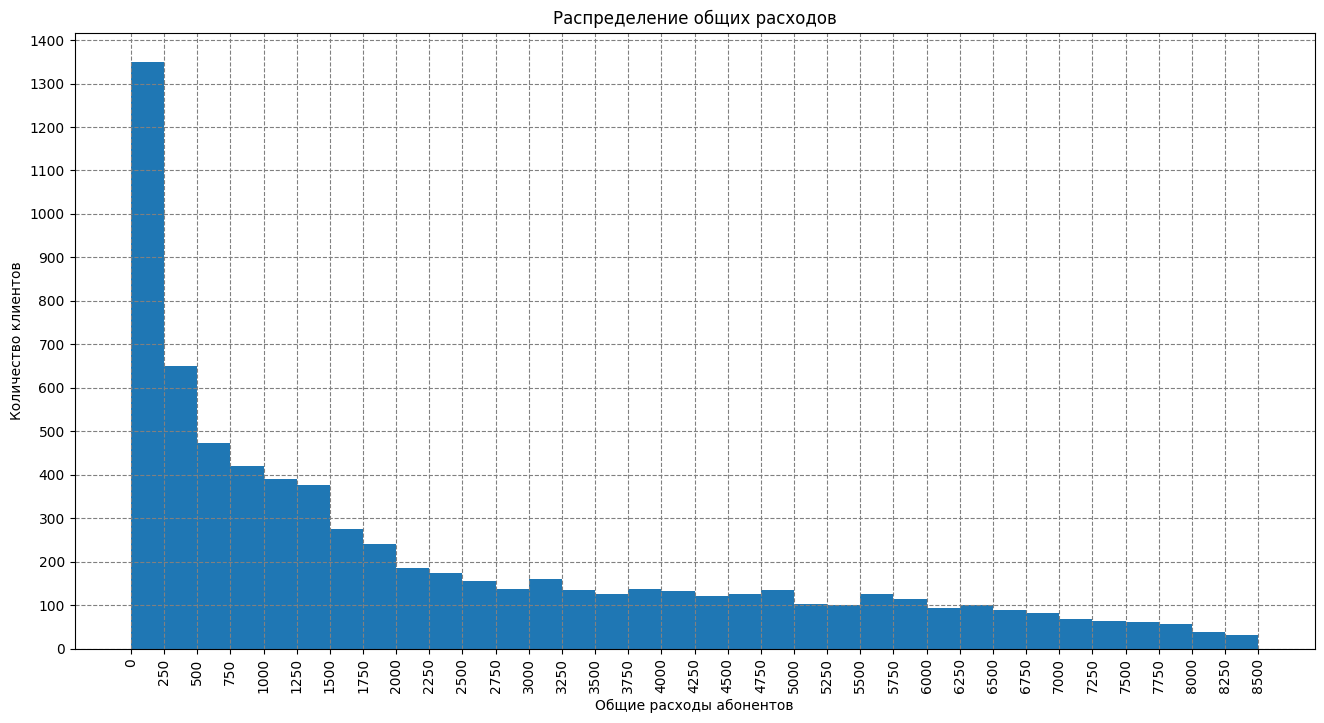

In [24]:
# Посмотрим распределение общих расходов
fig = plt.figure(figsize=(16, 8))
plt.title('Распределение общих расходов')
plt.grid(color='grey', linestyle='--')
plt.xlabel('Общие расходы абонентов')
plt.xticks(range(0, 8501, 250), rotation=90)
plt.ylabel('Количество клиентов')
plt.yticks(range(0, 2601, 100))
plt.hist(contract_df['TotalCharges'], bins=range(0, 8501, 250))
print(f'Пропусков {contract_df["TotalCharges"].isna().sum()}')
plt.show()

Выводы:
- имеется пик в диапазоне 0-250, далее распределение убывающее по мере роста общих расходов,
- имеется 11 пропусков.

In [25]:
# Рассмотрим информацию о договорах с пропусками
contract_df[contract_df["TotalCharges"].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_month,end_month
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,None,2020-02,NaT
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,None,2020-02,NaT
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,None,2020-02,NaT
6,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,None,2020-02,NaT
7,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,None,2020-02,NaT
9,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,None,2020-02,NaT
10,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.7,None,2020-02,NaT
11,2775-SEFEE,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),61.9,None,2020-02,NaT
4408,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,None,2020-02,NaT
5160,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20,None,2020-02,NaT


Видим, что это новые клиенты, которые пока не имели расходов, поэтому заполним пропуски нулями по полю общих расходов.

In [26]:
contract_df['TotalCharges'] = contract_df['TotalCharges'].fillna(0)

In [27]:
# Рассмотрим информацию о договорах с общими расходами менее 250
contract_df[(contract_df['TotalCharges'] > 0) & (contract_df['TotalCharges'] < 250)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_month,end_month
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,2018-08,2019-12
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.7,151.65,2019-01,2019-11
14,8779-QRDMV,2019-02-07,2019-12-01,Month-to-month,Yes,Electronic check,39.65,39.65,2019-02,2019-12
15,1066-JKSGK,2019-05-03,2019-12-01,Month-to-month,No,Mailed check,20.15,20.15,2019-05,2019-12
17,8665-UTDHZ,2019-07-28,2019-12-01,Month-to-month,No,Electronic check,30.2,30.2,2019-07,2019-12
...,...,...,...,...,...,...,...,...,...,...
6984,3078-ZKNTS,2019-08-22,NaT,Two year,Yes,Bank transfer (automatic),19.75,246.7,2019-08,NaT
6997,5351-QESIO,2019-01-18,NaT,Month-to-month,No,Mailed check,24.2,24.2,2019-01,NaT
7022,1471-GIQKQ,2018-11-30,NaT,Month-to-month,No,Electronic check,49.95,49.95,2018-11,NaT
7025,9837-FWLCH,2019-02-12,NaT,Month-to-month,Yes,Electronic check,19.2,239,2019-02,NaT


Видим, что имеются клиенты:
- которые подключены не так давно и пока не успели заплатить много,
- у которых при длительном сроке действия контракта общие расходы небольшие. Такие клиенты, вероятнее всего, неактивно пользуются услугами.

### Данные о клиентах

In [28]:
# Так как записей 7043, можем загрузить всю таблицу в датафрейм
# Проверим четвёртое условие
query = '''
      SELECT *
      FROM telecom.personal
'''

try:
    personal_df = pd.read_sql_query(query, con=engine)
    print(personal_df.info())
except:
    conn = engine.connect()
    personal_df = pd.DataFrame(conn.execute(text(query)))
    print(personal_df.info())
    conn.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


Имеются данные о 7043 клиентах, пропуски в данных отсутствуют.

In [29]:
# Рассмотрим данные о поле
personal_df['gender'].value_counts(normalize=True, dropna=False)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

Выводы:
- мужчин среди абонентов незначительно больше, чем женщин,
- аномалий и пропусков нет.

In [30]:
# Рассмотрим данные о пенсионном статусе
personal_df['SeniorCitizen'].value_counts(normalize=True, dropna=False)

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

In [31]:
# Так как признак категориальный, заменим на категории
personal_df['SeniorCitizen'] = personal_df['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')
personal_df['SeniorCitizen'].value_counts(normalize=True, dropna=False)

No     0.837853
Yes    0.162147
Name: SeniorCitizen, dtype: float64

Выводы:
- среди абонентов 83,8% не достигли пенсионного возраста,
- аномалий и пропусков нет.

In [32]:
# Рассмотрим данные о семейном статусе
personal_df['Partner'].value_counts(normalize=True, dropna=False)

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

Выводы:
- холостых среди абонентов незначительно больше, чем семейных,
- аномалий и пропусков нет.

In [33]:
# Рассмотрим данные о наличии или отсутствии детей
personal_df['Dependents'].value_counts(normalize=True, dropna=False)

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64

Выводы:
- среди абонентов 70% не имеет детей,
- аномалий и пропусков нет.

### Данные об интернет-услугах

In [34]:
# Так как записей 5518, можем загрузить всю таблицу в датафрейм
# Проверим четвёртое условие
query = '''
      SELECT *
      FROM telecom.internet
'''

try:
    internet_df = pd.read_sql_query(query, con=engine)
    print(internet_df.info())
except:
    conn = engine.connect()
    internet_df = pd.DataFrame(conn.execute(text(query)))
    print(internet_df.info())
    conn.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB
None


In [35]:
# Заменим наименования колонок
internet_df.columns = list(internet_df.iloc[0])
# Уберём первую строку
internet_df = internet_df.iloc[1:, :].reset_index(drop=True)
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Имеются данные о 5517 клиентах, которые используют или использовали интернет-услуги.

In [36]:
# Рассмотрим данные о типе подключения
internet_df['InternetService'].value_counts(normalize=True, dropna=False)

Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

Выводы:
- среди абонентов большинство подключены оптоволокном,
- аномалий и пропусков нет.

In [37]:
# Рассмотрим данные о наличии услуги блокировки опасных сайтов
internet_df['OnlineSecurity'].value_counts(normalize=True, dropna=False)

No     0.63404
Yes    0.36596
Name: OnlineSecurity, dtype: float64

Выводы:
- среди абонентов 63,4% не пользуются услугой блокировки опасных сайтов,
- аномалий и пропусков нет.

In [38]:
# Рассмотрим данные об услуге облачного хранилища
internet_df['OnlineBackup'].value_counts(normalize=True, dropna=False)

No     0.559724
Yes    0.440276
Name: OnlineBackup, dtype: float64

Выводы:
- среди абонентов 56% не пользуются облачных хранилищем,
- аномалий и пропусков нет.

In [39]:
# Рассмотрим данные об антивирусе
internet_df['DeviceProtection'].value_counts(normalize=True, dropna=False)

No     0.560993
Yes    0.439007
Name: DeviceProtection, dtype: float64

Выводы:
- среди абонентов 56,1% не пользуются антивирусом,
- аномалий и пропусков нет.

In [40]:
# Рассмотрим данные о выделенной линии поддержки
internet_df['TechSupport'].value_counts(normalize=True, dropna=False)

No     0.629509
Yes    0.370491
Name: TechSupport, dtype: float64

Выводы:
- среди абонентов 63% не пользуются выделенной линией поддержки,
- аномалий и пропусков нет.

In [41]:
# Рассмотрим данные об антивирусе
internet_df['StreamingTV'].value_counts(normalize=True, dropna=False)

No     0.509335
Yes    0.490665
Name: StreamingTV, dtype: float64

Выводы:
- приблизительно половина абонентов использует стриминговое телевидение,
- аномалий и пропусков нет.

In [42]:
# Рассмотрим данные о каталоге фильмов
internet_df['StreamingMovies'].value_counts(normalize=True, dropna=False)

No     0.504803
Yes    0.495197
Name: StreamingMovies, dtype: float64

Выводы:
- приблизительно половина абонентов использует стриминговое телевидение,
- аномалий и пропусков нет.

### Данные об услугах телефонии

In [43]:
# Так как записей 6362, можем загрузить всю таблицу в датафрейм
# Проверим четвёртое условие
query = '''
      SELECT *
      FROM telecom.phone
'''

try:
    phone_df = pd.read_sql_query(query, con=engine)
    print(phone_df.info())
except:
    conn = engine.connect()
    phone_df = pd.DataFrame(conn.execute(text(query)))
    print(phone_df.info())
    conn.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


In [44]:
# Заменим наименования колонок
phone_df.columns = list(phone_df.iloc[0])
# Уберём первую строку
phone_df = phone_df.iloc[1:, :].reset_index(drop=True)
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Имеются данные о 6361 клиентах, которые используют или использовали услуги телефонии.

In [45]:
# Рассмотрим данные о подключении телефона к нескольким линиям
phone_df['MultipleLines'].value_counts(normalize=True, dropna=False)

No     0.532935
Yes    0.467065
Name: MultipleLines, dtype: float64

Выводы:
- среди абонентов 53,3% не используют подключение телефона к нескольким линиям,
- аномалий и пропусков нет.

### Выводы по таблицам базы данных
- таблицы и колонки в таблицах соответствуют описанию базы данных, имеется общий ключ `customerID` для связи таблиц,
- во всех таблицах имеются данные,
- пропуски в таблице о договорах заполнены, в остальных таблицах пропусков нет,
- аномалии в данных не выявлены.

## Объединение таблиц

In [46]:
# Объединим таблицы по ID клиента.
df = personal_df.merge(
    contract_df, how='left', left_on='customerID', right_on='customerID', validate='1:1'
).merge(
    internet_df, how='left', left_on='customerID', right_on='customerID', validate='1:1'
).merge(
    phone_df, how='left', left_on='customerID', right_on='customerID', validate='1:1'
)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,begin_month,end_month,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,No,Yes,No,2019-04-29,NaT,Month-to-month,Yes,Electronic check,...,2019-04,NaT,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,No,No,No,2019-03-26,NaT,One year,No,Mailed check,...,2019-03,NaT,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,No,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,...,2018-08,2019-12,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,No,No,No,2018-12-22,NaT,One year,No,Bank transfer (automatic),...,2018-12,NaT,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,No,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,...,2019-01,2019-11,Fiber optic,No,No,No,No,No,No,No


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   object        
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           1869 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   object        
 11  TotalCharges      7043 non-null   object        
 12  begin_month       7043 non-null   period[M]     
 13  end_month         1869 non-null   period[M]     
 14  InternetService   5517 n

Каждому клиенту соответствует одно наблюдение. Заполним пропуски в полях `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`,`TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` значением, которое обозначает отсутствие услуги.

### Пропуски и целевая переменная

In [48]:
for col_name in ['InternetService', 'OnlineSecurity', 'OnlineBackup',
                 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies',
                 'MultipleLines']:
    df[col_name] = df[col_name].fillna('No')

In [49]:
# Выделим целевую переменную по наличию даты окончания договора
df.loc[~df['EndDate'].isna(), 'is_not_client'] = 1
df.loc[df['EndDate'].isna(), 'is_not_client'] = 0
df['is_not_client'].value_counts(normalize=True)

0.0    0.73463
1.0    0.26537
Name: is_not_client, dtype: float64

Видим, что классы не сбалансированы, поэтому будем применять в дальнейшем балансировку.  
Сгенерируем новые признаки, которые могут пригодиться при обучении.

### Новые признаки

In [50]:
# Рассчитаем длительность контракта абонента.
# По действующим контрактам текущую дату примем 01.02.2020 г.
df['contract_duration'] = (df['EndDate'].fillna(
    pd.to_datetime('2020-02-01', format='%Y-%m-%d')
) - df['BeginDate']).dt.days

# Сами даты начала и окончания не представляют интереса, удалим их
df = df.drop(['BeginDate', 'EndDate', 'begin_month', 'end_month'], axis=1)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   gender             7043 non-null   object 
 2   SeniorCitizen      7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Type               7043 non-null   object 
 6   PaperlessBilling   7043 non-null   object 
 7   PaymentMethod      7043 non-null   object 
 8   MonthlyCharges     7043 non-null   object 
 9   TotalCharges       7043 non-null   object 
 10  InternetService    7043 non-null   object 
 11  OnlineSecurity     7043 non-null   object 
 12  OnlineBackup       7043 non-null   object 
 13  DeviceProtection   7043 non-null   object 
 14  TechSupport        7043 non-null   object 
 15  StreamingTV        7043 non-null   object 
 16  StreamingMovies    7043 

Проведём исследовательский анализ данных объединённой таблицы. Посмотрим соотношение ушедших и оставшихся клиентов для каждого признака. Проведём корреляционный анализ.

### Анализ данных объединённой таблицы

In [52]:
# Определим долю ушедших клиентов
average = df['is_not_client'].mean()

In [53]:
# Определим функцию для построения графиков. На вход подаётся таблица с данными
# по соотношению ушедших и оставшихся клиентов с группировкой по признаку
# Слева покажем количество действующих и ушедших клиентов, а справа - доли ушедших клиентов.
def show_factor(data, ax, factor_name, rotation=0):
    for ax_i in ax:
        ax_i.grid(color='gray', linewidth=0.5, linestyle='--')
        ax_i.set_xticks(range(len(data.index)))
        ax_i.set_xticklabels(data.index, rotation=rotation)
    ax[0].set_ylabel(factor_name, fontsize='small')
    x_axis = np.arange(data.shape[0])
    ax[0].bar(x_axis - 0.15, data['count'], width=0.3, label='Всего абонентов')
    ax[0].bar(
        x_axis + 0.15,
        data['sum'],
        width=0.3,
        color='red',
        label='Ушло абонентов',
        alpha=0.8
    )
    ax[0].legend()
    ax[1].bar(x_axis, data['mean'])
    ax[1].plot(
        [x_axis[0], x_axis[-1]],
        [average] * 2,
        color='red',
        label='В среднем по выборке',
        linestyle='--'
    )
    ax[1].legend()

#### Параметры контракта

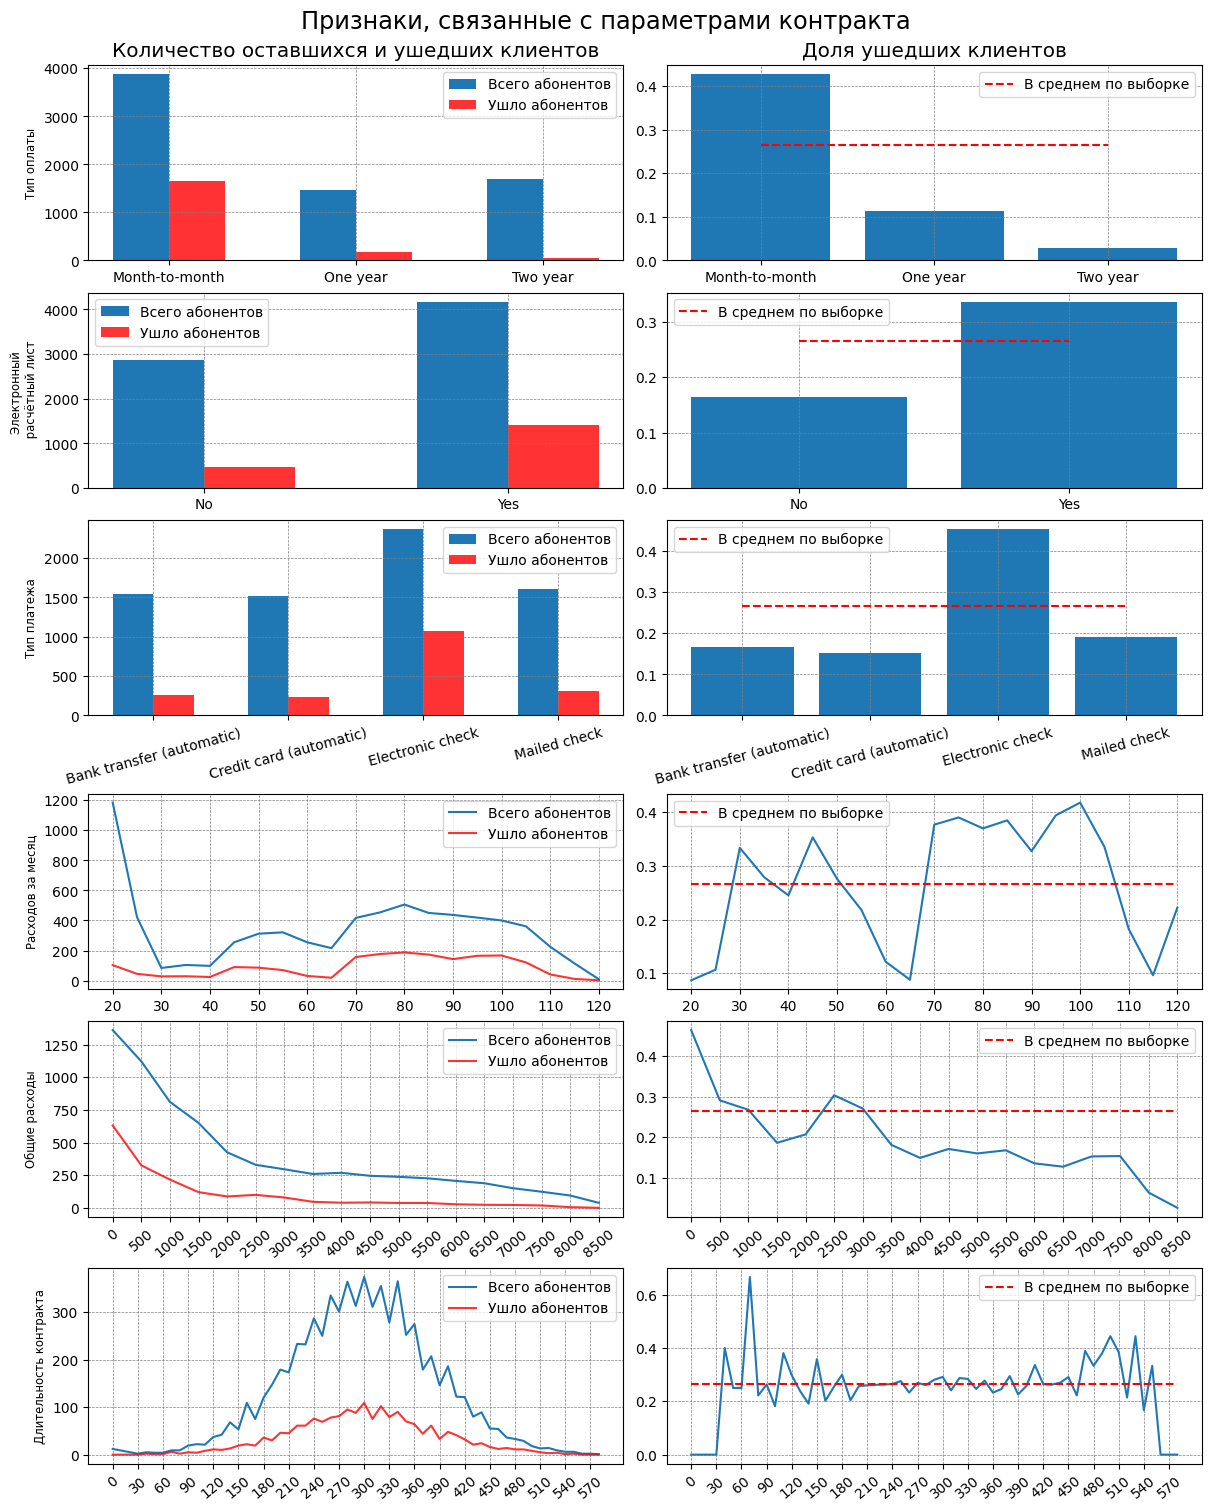

In [54]:
# Посмотрим соотношение ушедших и оставшихся клиентов для признаков, связанных с договором.
# Слева покажем количество действующих и ушедших клиентов, а справа - доли ушедших клиентов.
# Настроим внешний вид области построения, обозначим оси
fig, ax = plt.subplots(
    ncols=2,
    nrows=6,
    figsize=(12, 15),
    sharex=False,
    gridspec_kw={'width_ratios': (0.5, 0.5)},
    constrained_layout=True,
)
fig.suptitle('Признаки, связанные с параметрами контракта', fontsize='xx-large')
ax[0, 0].set_title('Количество оставшихся и ушедших клиентов', fontsize='x-large')
ax[0, 1].set_title('Доля ушедших клиентов', fontsize='x-large')
type_data = df.groupby(by='Type')['is_not_client'].agg(['count', 'sum', 'mean'])
bill_data = df.groupby(by='PaperlessBilling')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)
pay_data = df.groupby(by='PaymentMethod')['is_not_client'].agg(['count', 'sum', 'mean'])

# округлим до 5 значение ежемесячных расходов
df['MonthlyCharges'] = df['MonthlyCharges'].apply(lambda x: 5 * (round(x / 5)))
month_charge_data = df.groupby(by='MonthlyCharges')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)
# округлим до 500 значение общих расходов
df['total_charges_500'] = df['TotalCharges'].apply(lambda x: 500 * (round(x / 500)))
total_charge_data = df.groupby(by='total_charges_500')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)

# округлим до 10 дней длительность контракта
df['contract_duration_10'] = df['contract_duration'].apply(
    lambda x: 10 * (round(x / 10))
)
contract_duration_data = df.groupby(by='contract_duration_10')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)

# Построим графики
# Тип оплаты
show_factor(data=type_data, ax=ax[0, :], factor_name='Тип оплаты')

# Электронный расчётный лист
show_factor(data=bill_data, ax=ax[1, :], factor_name='Электронный \n расчётный лист')

# Тип платежа
show_factor(data=pay_data, ax=ax[2, :], factor_name='Тип платежа', rotation=15)

for i in range(3, 6):
    for j in range(0, 2):
        ax[i, j].grid(color='gray', linewidth=0.5, linestyle='--')
        if i == 3:
            ax[i, j].set_xticks(range(0, month_charge_data.index.max() + 1, 10))
            ax[i, j].set_xticklabels(range(0, month_charge_data.index.max() + 1, 10))
        if i == 4:
            ax[i, j].set_xticks(range(0, total_charge_data.index.max() + 1, 500))
            ax[i, j].set_xticklabels(
                range(0, total_charge_data.index.max() + 1, 500), rotation=40
            )
        if i == 5:
            ax[i, j].set_xticks(range(0, contract_duration_data.index.max() + 1, 30))
            ax[i, j].set_xticklabels(
                range(0, contract_duration_data.index.max() + 1, 30), rotation=40
            )

# Построим графики для расходов за месяц
ax[3, 0].set_ylabel('Расходов за месяц', fontsize='small')
ax[3, 0].plot(month_charge_data['count'], label='Всего абонентов')
ax[3, 0].plot(month_charge_data['sum'], color='red', label='Ушло абонентов', alpha=0.8)
ax[3, 0].legend()
ax[3, 1].plot(month_charge_data['mean'])
ax[3, 1].plot(
    [month_charge_data.index[0], month_charge_data.index[-1]],
    [average] * 2,
    color='red',
    label='В среднем по выборке',
    linestyle='--'
)
ax[3, 1].legend()

# Построим графики для общих расходов
ax[4, 0].set_ylabel('Общие расходы', fontsize='small')
ax[4, 0].plot(total_charge_data['count'], label='Всего абонентов')
ax[4, 0].plot(total_charge_data['sum'], color='red', label='Ушло абонентов', alpha=0.8)
ax[4, 0].legend()
ax[4, 1].plot(total_charge_data['mean'])
ax[4, 1].plot(
    [total_charge_data.index[0], total_charge_data.index[-1]],
    [average] * 2,
    color='red',
    label='В среднем по выборке',
    linestyle='--'
)
ax[4, 1].legend()

# Построим графики для длительности действия контракта
ax[5, 0].set_ylabel('Длительность контракта', fontsize='small')
ax[5, 0].plot(contract_duration_data['count'], label='Всего абонентов')
ax[5, 0].plot(
    contract_duration_data['sum'], color='red', label='Ушло абонентов', alpha=0.8
)
ax[5, 0].legend()
ax[5, 1].plot(contract_duration_data['mean'])
ax[5, 1].plot(
    [contract_duration_data.index[0], contract_duration_data.index[-1]],
    [average] * 2,
    color='red',
    label='В среднем по выборке',
    linestyle='--'
)
ax[5, 1].legend()
plt.show()

По имеющимся данным можно сделать выводы:
- среди клиентов с ежемесячной оплатой доля ушедших выше, чем при оплате раз в год или два;
- среди клиентов с электронным расчётным листом доля ушедших выше, чем с бумажным расчётным листом;
- среди клиентов с ежемесячными расходами 30-50, 70-105 доля ушедших выше;
- среди клиентов с общим расходами до 1000 доля ушедших выше, а с общими расходами 3000 и выше - реже. При этом можно выделить 4 категории клиентов по общим расходам: с расходам до 1000, от 1000 до 3000, от 3000 до 4000 и более 4000. Преобразуем этот признак в категориальный.;
- по длительности контракта можно выделить три категории: до 90 дней, более 450 дней и остальные. Преобразуем этот признак в категориальный.

In [55]:
# Освободим оперативную память
df = df.drop(['total_charges_500','contract_duration_10'], axis=1)
del type_data, bill_data, pay_data, month_charge_data, total_charge_data, contract_duration_data
gc.collect()

10091

In [56]:
def client_charges_cat(total_charges):
    if total_charges <= 1000:
        return 'clients_1000'
    elif total_charges > 1000 and total_charges <= 3000:
        return 'clients_1000-3000'
    elif total_charges > 3000 and total_charges <= 4000:
        return 'clients_3000-4000'
    else:
        return 'clients_4000'
df['total_charges_cat'] = df['TotalCharges'].apply(client_charges_cat)
df = df.drop(['TotalCharges'], axis=1)
df['total_charges_cat'].value_counts()

clients_1000         2904
clients_1000-3000    1935
clients_4000         1648
clients_3000-4000     556
Name: total_charges_cat, dtype: int64

In [57]:
def client_duration_cat(contract_duration):
    if contract_duration <= 30:
        return 'clients_30'
    elif contract_duration > 30 and contract_duration <= 80:
        return 'clients_30-80'
    elif contract_duration > 80 and contract_duration <= 450:
        return 'clients_80-450'
    elif contract_duration > 450 and contract_duration <= 540:
        return 'clients_450-540'
    else:
        return 'clients_540'
df['contract_duration_cat'] = df['contract_duration'].apply(client_duration_cat)
df = df.drop(['contract_duration'], axis=1)
df['contract_duration_cat'].value_counts()

clients_80-450     6749
clients_450-540     238
clients_30-80        29
clients_540          14
clients_30           13
Name: contract_duration_cat, dtype: int64

#### Данные клиентов

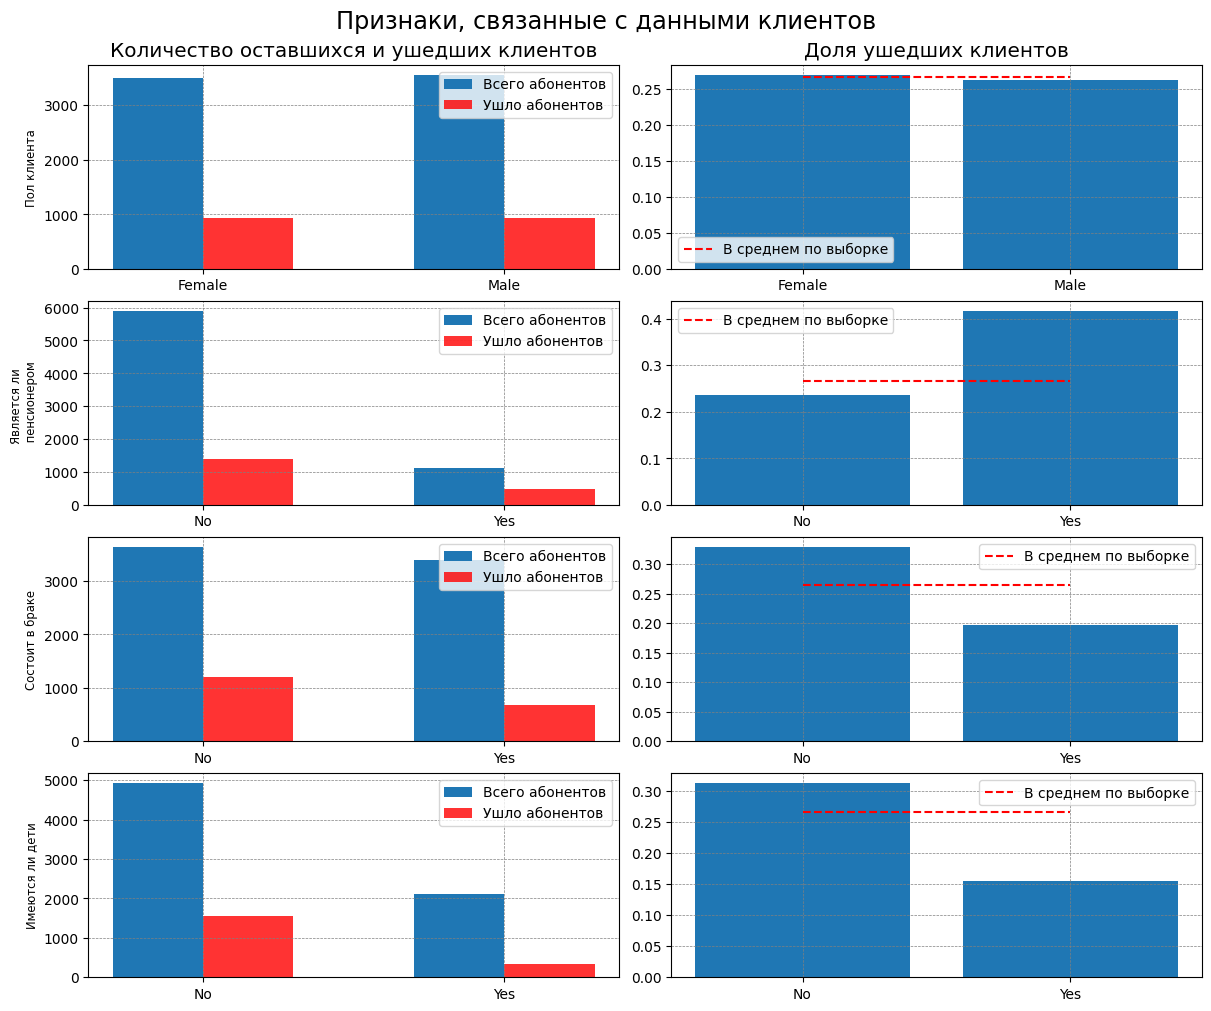

In [58]:
# Посмотрим соотношение ушедших и оставшихся клиентов для признаков, связанных с данными клиентов.
# Слева покажем количество действующих и ушедших клиентов, а справа - доли ушедших клиентов.
# Настроим внешний вид области построения, обозначим оси
fig, ax = plt.subplots(
    ncols=2,
    nrows=4,
    figsize=(12, 10),
    sharex=False,
    gridspec_kw={'width_ratios': (0.5, 0.5)},
    constrained_layout=True,
)
fig.suptitle('Признаки, связанные с данными клиентов', fontsize='xx-large')
ax[0, 0].set_title('Количество оставшихся и ушедших клиентов', fontsize='x-large')
ax[0, 1].set_title('Доля ушедших клиентов', fontsize='x-large')
gender_data = df.groupby(by='gender')['is_not_client'].agg(['count', 'sum', 'mean'])
senior_data = df.groupby(by='SeniorCitizen')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)
partner_data = df.groupby(by='Partner')['is_not_client'].agg(['count', 'sum', 'mean'])
dependents_data = df.groupby(by='Dependents')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)

# Построим графики
# пол клиента
show_factor(data=gender_data, ax=ax[0, :], factor_name='Пол клиента')

# пенсионный статус
show_factor(data=senior_data, ax=ax[1, :], factor_name='Является ли \n пенсионером')

# семейный статус
show_factor(data=partner_data, ax=ax[2, :], factor_name='Состоит в браке')

# наличие или отсутствие детей
show_factor(data=dependents_data, ax=ax[3, :], factor_name='Имеются ли дети')

ax[1, 0].set_xticklabels(['No', 'Yes'])
ax[1, 1].set_xticklabels(['No', 'Yes'])
plt.show()

По имеющимся данным можно сделать выводы:
- доля ушедших клиентов одинакова среди мужчин и женщин,
- среди пенсионеров доля ушедших клиентов выше,
- среди холостых доля ушедших клиентов выше,
- у клиентов с детьми доля ушедших ниже.

In [59]:
# Освободим оперативную память
del gender_data, senior_data, partner_data, dependents_data
gc.collect()

44557

#### Интернет-услуги

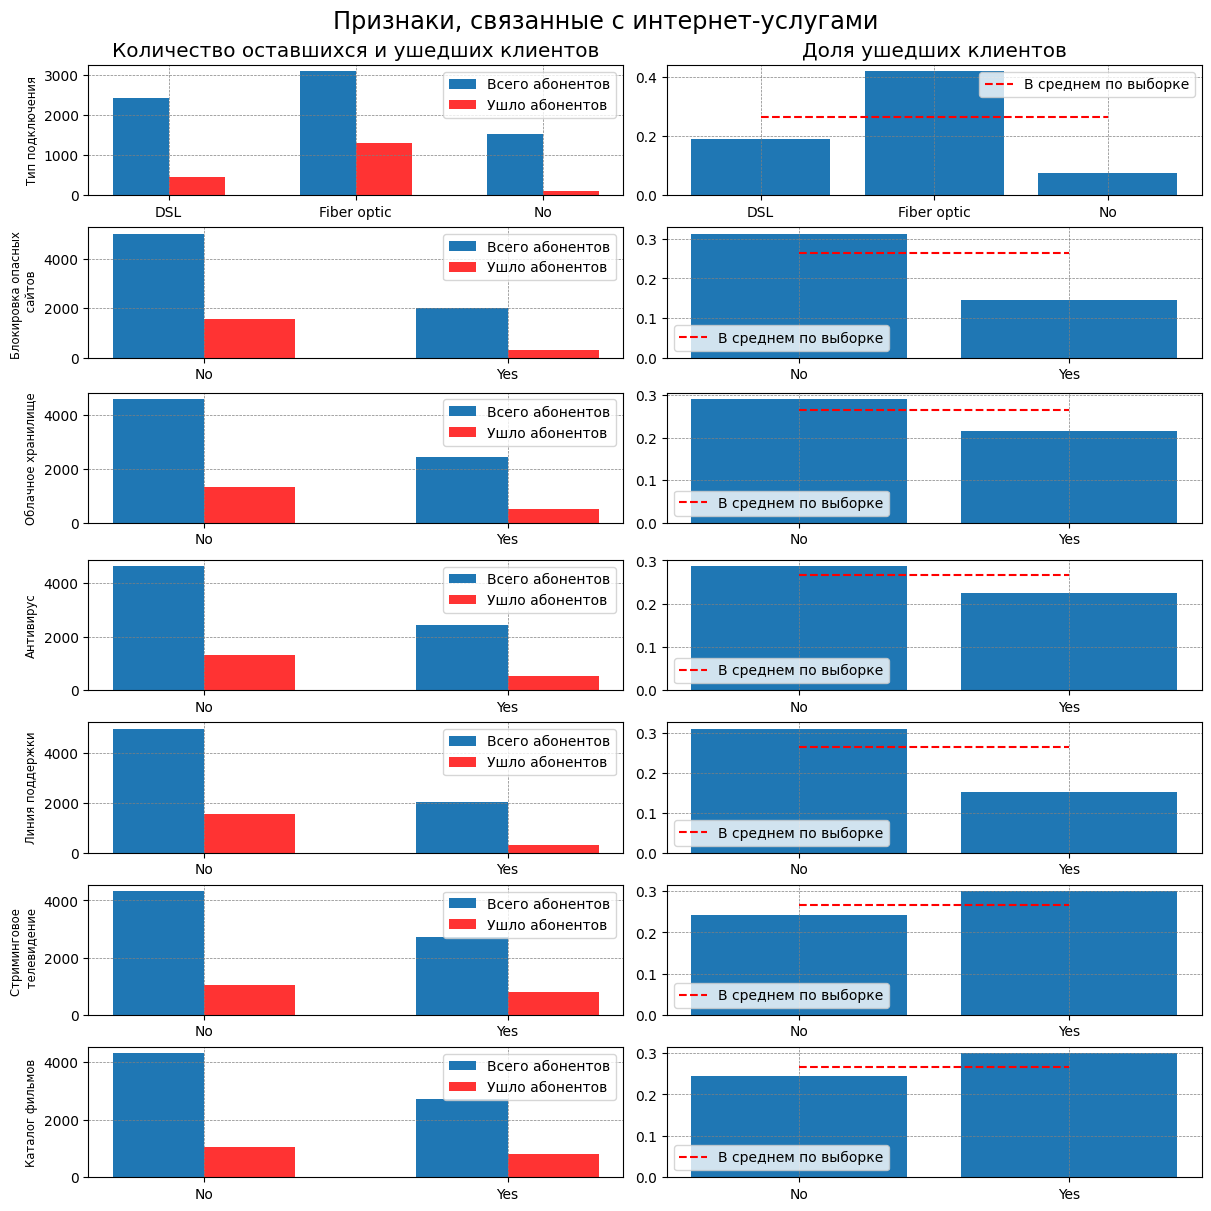

In [60]:
# Посмотрим соотношение ушедших и оставшихся клиентов для признаков, связанных с интернет-услугами.
# Настроим внешний вид области построения, обозначим оси
fig, ax = plt.subplots(
    ncols=2,
    nrows=7,
    figsize=(12, 12),
    sharex=False,
    gridspec_kw={'width_ratios': (0.5, 0.5)},
    constrained_layout=True,
)
fig.suptitle('Признаки, связанные с интернет-услугами', fontsize='xx-large')
ax[0, 0].set_title('Количество оставшихся и ушедших клиентов', fontsize='x-large')
ax[0, 1].set_title('Доля ушедших клиентов', fontsize='x-large')
service_data = df.groupby(by='InternetService')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)
security_data = df.groupby(by='OnlineSecurity')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)
backup_data = df.groupby(by='OnlineBackup')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)
protection_data = df.groupby(by='DeviceProtection')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)
support_data = df.groupby(by='TechSupport')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)
tv_data = df.groupby(by='StreamingTV')['is_not_client'].agg(['count', 'sum', 'mean'])
movies_data = df.groupby(by='StreamingMovies')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)

# Построим графики
# тип подключения
show_factor(data=service_data, ax=ax[0, :], factor_name='Тип подключения')

# услуга блокировки опасных сайтов
show_factor(data=security_data, ax=ax[1, :], factor_name='Блокировка опасных \n сайтов')

# облачное хранилище
show_factor(data=backup_data, ax=ax[2, :], factor_name='Облачное хранилище')

# антивирус
show_factor(data=protection_data, ax=ax[3, :], factor_name='Антивирус')

# выделенная линия поддержки
show_factor(data=support_data, ax=ax[4, :], factor_name='Линия поддержки')

# стриминговое телевидение
show_factor(data=tv_data, ax=ax[5, :], factor_name='Стриминговое \n телевидение')

# каталог фильмов
show_factor(data=movies_data, ax=ax[6, :], factor_name='Каталог фильмов')

plt.show()

По имеющимся данным можно сделать выводы:
- среди клиентов, подключенных через оптоволокно, доля ушедших выше,
- среди клиентов, не подключавших блокировку опасных сайтов, облачное хранилище, антивирус, выделенную линию поддержки доля ушедших выше,
- среди клиентов, подключивших стриминговое телевидение и каталог фильмов, доля ушедших выше.

In [61]:
# Освободим оперативную память
del service_data, security_data, backup_data, protection_data, support_data, tv_data, movies_data
gc.collect()

23369

#### Услуги телефонии

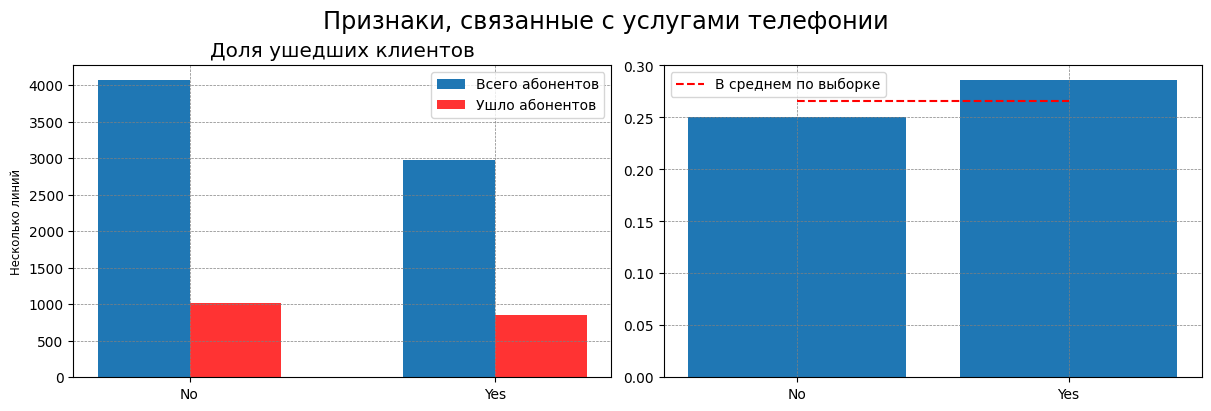

In [62]:
# Посмотрим соотношение ушедших и оставшихся клиентов для признаков, связанных с услугами телефонии.
# Настроим внешний вид области построения, обозначим оси
fig, ax = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(12, 4),
    sharex=False,
    gridspec_kw={'width_ratios': (0.5, 0.5)},
    constrained_layout=True,
)
fig.suptitle('Признаки, связанные с услугами телефонии', fontsize='xx-large')
ax[0].set_title('Количество оставшихся и ушедших клиентов', fontsize='x-large')
ax[0].set_title('Доля ушедших клиентов', fontsize='x-large')
lines_data = df.groupby(by='MultipleLines')['is_not_client'].agg(
    ['count', 'sum', 'mean']
)

# Построим график
show_factor(data=lines_data, ax=ax, factor_name='Несколько линий')

plt.show()

По имеющимся данным можно сделать вывод:
- среди клиентов, подключивших несколько телефонных линий, доля ушедших выше.

In [63]:
# Освободим оперативную память
del lines_data
gc.collect()

37700

#### Корреляционный анализ

In [64]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'is_not_client', 'total_charges_cat', 'contract_duration_cat'],
      dtype='object')

In [65]:
# Воспользуемся библиотекой Phik для построения матрицы корреляции признаков
cor_matrix = df.drop(['customerID'], axis=1).phik_matrix(
    interval_cols=['MonthlyCharges'], bins={'MonthlyCharges': 20}
)

In [66]:
cor_matrix['is_not_client'].sort_values(ascending=False)

is_not_client            1.000000
PaymentMethod            0.449125
MonthlyCharges           0.354316
total_charges_cat        0.309223
PaperlessBilling         0.295754
OnlineSecurity           0.264580
TechSupport              0.254615
Dependents               0.253936
Type                     0.251639
SeniorCitizen            0.233432
Partner                  0.232930
InternetService          0.196202
OnlineBackup             0.126973
DeviceProtection         0.101516
StreamingTV              0.096865
StreamingMovies          0.093923
MultipleLines            0.059581
contract_duration_cat    0.029347
gender                   0.000000
Name: is_not_client, dtype: float64

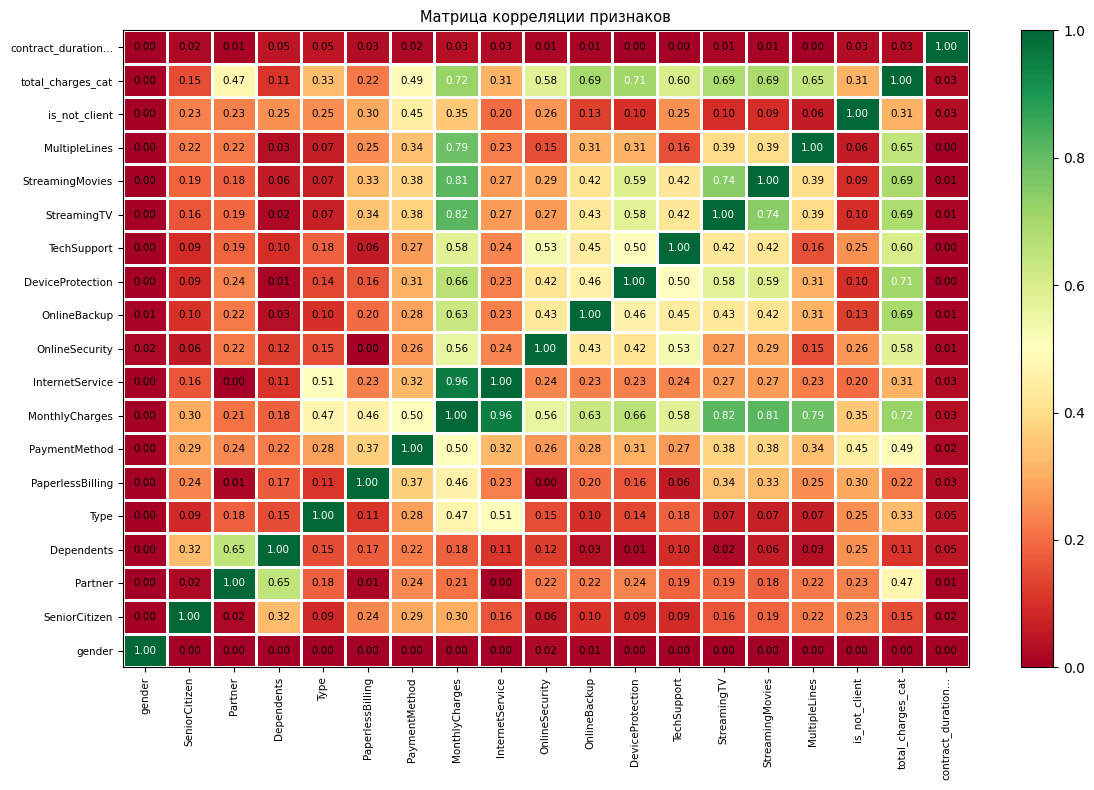

In [67]:
zvalues = cor_matrix.values
xlabels = cor_matrix.columns
ylabels = cor_matrix.index
plot_correlation_matrix(
    zvalues,
    x_labels=xlabels,
    y_labels=ylabels,
    vmin=0,
    vmax=1,
    title='Матрица корреляции признаков',
    identity_layout=False,
    fontsize_factor=0.75,
    figsize=(12,8)
)

По данным корреляции можно сделать выводы:
- признак `gender` никак не связан с целевым, избавимся от него при подготовке данных к моделированию,
- признак `MonthlyCharges` коррелируют с несколькими другими признаками, при этом сильно связан с целевым, поэтому оставим его.

## Подготовка набора данных для моделирования

### Выбор признаков

In [68]:
# Выведем информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customerID             7043 non-null   object 
 1   gender                 7043 non-null   object 
 2   SeniorCitizen          7043 non-null   object 
 3   Partner                7043 non-null   object 
 4   Dependents             7043 non-null   object 
 5   Type                   7043 non-null   object 
 6   PaperlessBilling       7043 non-null   object 
 7   PaymentMethod          7043 non-null   object 
 8   MonthlyCharges         7043 non-null   int64  
 9   InternetService        7043 non-null   object 
 10  OnlineSecurity         7043 non-null   object 
 11  OnlineBackup           7043 non-null   object 
 12  DeviceProtection       7043 non-null   object 
 13  TechSupport            7043 non-null   object 
 14  StreamingTV            7043 non-null   object 
 15  Stre

С учётом исследований, проведённых в разделе 4, для моделирования выберем следующие признаки:
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `InternetService` - тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов;
- `MultipleLines` - подключение телефона к нескольким линиям одновременно;
- `total_charges_cat` — категория клиента по общим расходам;
- `contract_duration_cat` - категория клиента в зависимости от длительности контракта;
- `is_not_client` - ушёл ли клиент (целевой признак).

In [69]:
df = df.drop(['customerID', 'gender'], axis=1)

### Разделение выборки

In [70]:
# Разделим датасет на обучающую и тестовую выборки
train, test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)
print(f'Обучающая выборка: {train.shape[0]} ({train.shape[0]/df.shape[0]:.2f})')
print(f'Тестовая выборка: {test.shape[0]} ({test.shape[0]/df.shape[0]:.2f})')

Обучающая выборка: 5282 (0.75)
Тестовая выборка: 1761 (0.25)


In [71]:
train.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines', 'is_not_client',
       'total_charges_cat', 'contract_duration_cat'],
      dtype='object')

In [72]:
# Разделим признаки
X = [
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'MonthlyCharges',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines',
    'total_charges_cat',
    'contract_duration_cat',
]
y = ['is_not_client']

In [73]:
# Составим список категориальных признаков
cat_features = train[X].select_dtypes(include='object').columns.to_list()
cat_features

['SeniorCitizen',
 'Partner',
 'Dependents',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'total_charges_cat',
 'contract_duration_cat']

In [74]:
# Составим список числовых признаков
num_features = (
    train[X]
    .select_dtypes(include=['int64', 'int32', 'float32', 'float64'])
    .columns.to_list()
)
num_features

['MonthlyCharges']

Для решения поставленной задачи будем использовать модель случайного леса, классификаторы на основе градиентного бустинга из библиотеки catboost и библиотеки LightGBM, а также полносвязную нейронную сеть.
Для оценки качества и выбора модели будем использовать площадь под ROC (roc auc), чтоб понять, насколько качественно модель выполняет разделение классов.

В дальнейшем, чтоб максимизировать долю правильных предсказаний при разумной доле ошибочных предсказаний подберём значение порога для выбранной модели с максимальной площадью под ROC.

## Обучение моделей

### Константная модель

In [75]:
# Создадим и обучим константную модель, которая всегда возвращает одно значение
dummy_clf = DummyClassifier(strategy='prior', constant=None, random_state=RANDOM_STATE)
dummy_clf.fit(train[X], train[y])

DummyClassifier(random_state=20231212)

In [76]:
# Проверим качество. roc_auc
predicted_dummy = dummy_clf.predict_proba(test[X])[:, 1]
roc_auc_score(test[y], predicted_dummy)

0.5

### Модель на основе случайного леса

In [77]:
# Преобразователь признаков для модели случайного леса и модели LightGBM
try:
    col_transformer_forest = make_column_transformer(
        (
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            cat_features,
        ),
        (MinMaxScaler(), num_features),
        remainder='passthrough',
    verbose_feature_names_out=False
    )
except:
    col_transformer_forest = make_column_transformer(
        (
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            cat_features,
        ),
        (MinMaxScaler(), num_features),
        remainder='passthrough'
    )

In [78]:
# Пайплайн для модели случайного леса
model_forest = RandomForestClassifier(
    random_state=RANDOM_STATE, class_weight='balanced'
)
pipline_rf = make_pipeline(col_transformer_forest, model_forest)

param_grid_rf = {
    'randomforestclassifier__n_estimators': range(10, 101, 5),
    'randomforestclassifier__max_depth': range(2, 41, 2),
    'randomforestclassifier__min_samples_split': np.arange(0.05, 0.7, step=0.05),
    'randomforestclassifier__min_samples_leaf': range(1, 11, 1),
}

# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf,
    param_distributions=param_grid_rf,
    scoring='roc_auc',
    n_jobs=-1,
    cv=4,
    random_state=RANDOM_STATE,
)

# Модель на основе случайного леса
gs_rf.fit(train[X], train[y].values.ravel())
gs_rf_best_score = gs_rf.best_score_
gs_rf_best_params = gs_rf.best_params_

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_rf_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_rf_best_params}')

best_score: 0.8264888453399917
best_params: {'randomforestclassifier__n_estimators': 25, 'randomforestclassifier__min_samples_split': 0.15000000000000002, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_depth': 18}


### Градиентный бустинг (библиотека  LightGBM)

In [79]:
# Данные для модели
try:
    X_train_LGBM = pd.DataFrame(
        col_transformer_forest.fit_transform(train[X]),
        columns=col_transformer_forest.get_feature_names_out()
    )
    X_test_LGBM = pd.DataFrame(
        col_transformer_forest.transform(test[X]),
        columns=col_transformer_forest.get_feature_names_out()
    )
except:
    X_train_LGBM = pd.DataFrame(
        col_transformer_forest.fit_transform(train[X]),
        columns = col_transformer_forest.transformers_[0][2] \
                + col_transformer_forest.transformers_[1][2]
    )
    X_test_LGBM = pd.DataFrame(
        col_transformer_forest.transform(test[X]),
        columns=col_transformer_forest.transformers_[0][2] \
              + col_transformer_forest.transformers_[1][2]
    )

# Модель
lgbm = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')

In [80]:
# Данные для подбора гиперпараметров
grid_param_lgbm = {
    'learning_rate': np.arange(0.001, 0.11, 0.01),
    'reg_lambda': np.arange(0.05, 0.51, 0.05),
}
# Градиентный бустинг (библиотека LightGBM) с ordinal encoding
grid_lgbm = GridSearchCV(
    estimator=lgbm, param_grid=grid_param_lgbm, scoring='roc_auc', cv=4, n_jobs=-1
)
grid_lgbm.fit(X_train_LGBM, train[y].values.ravel())

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {grid_lgbm.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {grid_lgbm.best_params_}')

[LightGBM] [Info] Number of positive: 1426, number of negative: 3856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
best_score: 0.8272433711234505
best_params: {'learning_rate': 0.011, 'reg_lambda': 0.15000000000000002}


### Градиентный бустинг (библиотека catboost)

In [81]:
# Преобразователь признаков для модели catboost
try:
    col_transformer_catboost = make_column_transformer(
    (MinMaxScaler(), num_features),
    remainder='passthrough',
    verbose_feature_names_out=False
    )
except:
    col_transformer_catboost = make_column_transformer(
    (MinMaxScaler(), num_features),
    remainder='passthrough'
    )

In [82]:
# Данные для модели
try:
    X_train_cb = pd.DataFrame(
        col_transformer_catboost.fit_transform(train[X]),
        columns=col_transformer_catboost.get_feature_names_out(),
    )
    X_test_cb = pd.DataFrame(
        col_transformer_catboost.transform(test[X]),
        columns=col_transformer_catboost.get_feature_names_out(),
    )
except:
    X_train_cb = pd.DataFrame(
        col_transformer_catboost.fit_transform(train[X]),
        columns=col_transformer_catboost.transformers_[0][2] \
              + list(pd.Series(X)[col_transformer_catboost.transformers_[1][2]])
    )
    X_test_cb = pd.DataFrame(
        col_transformer_catboost.transform(test[X]),
        columns=col_transformer_catboost.transformers_[0][2] \
              + list(pd.Series(X)[col_transformer_catboost.transformers_[1][2]])
    )

# Модель
cb = CatBoostClassifier(
    cat_features=cat_features,
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    logging_level='Silent',
    early_stopping_rounds=20,
    auto_class_weights='Balanced'
)

In [83]:
# Данные для подбора гиперпараметров
grid_param_cb = {'learning_rate': np.arange(0.001, 0.11, 0.01), 'iterations': [2000]}
# Градиентный бустинг (библиотека catboost)
grid_cb = GridSearchCV(
    estimator=cb, param_grid=grid_param_cb, scoring='roc_auc', cv=4, n_jobs=-1
)
grid_cb.fit(X_train_cb, train[y])

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {grid_cb.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {grid_cb.best_params_}')

best_score: 0.8342329944472544
best_params: {'iterations': 2000, 'learning_rate': 0.001}


### Полносвязная нейронная сеть

In [84]:
# Определим трансформер для векторизации и добавления столбцов со скоростью речи,
# частотой слов из словаря Oxford (векторизация Bag of words)
class to_float_transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return torch.FloatTensor(X)

In [85]:
try:
    # Преобразователь признаков для нейронной сети
    col_transformer_net = make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
        (MinMaxScaler(), num_features),
        remainder='passthrough',
        verbose_feature_names_out=False
    )
except:
    col_transformer_net = make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='error'), cat_features),
        (MinMaxScaler(), num_features),
        remainder='passthrough'
    )
X_train_transformed = col_transformer_net.fit_transform(train[X])
X_train_transformed.shape

(5282, 26)

In [86]:
# Зададим коичество нейронов на входе и на выходе
n_in_neurons = X_train_transformed.shape[1]
n_out_neurons = 1

In [87]:
# Преобразуем в тензор столбец с целевым признаком
y_train = torch.FloatTensor(train[y].values).flatten()
y_test = torch.FloatTensor(test[y].values).flatten()

In [88]:
# Зададим устройство, на котором будет работать нейронная сеть
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

В качестве базовой модели возьмём нейронную сеть с одним скрытым слоем.

Параметры сети:
- количество нейронов во входном слое - 18 (по числу признаков),
- количество нейронов в выходном слое - 1,
- количество нейронов в скрытом слое будем перебирать от $\sqrt{26*1} \approx 5$ (примем 8) до $(26+1)*(2/3)=18$ (примем 16) по степеням двойки 8, 16, а также добавим вариант 32,
- функция активации скрытого слоя - ReLU, выходного слоя - Sigmoid,
- инициализация весов модели - по умолчанию,
- функция потерь - бинарная кросс-энтропия, BCELoss,
- метрика - roc_auc.

In [89]:
# Создадим класс для задания архитектуры нейронной сети
class Net_1(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net_1, self).__init__()
        self.n_in_neurons = n_in_neurons
        self.n_hidden_neurons = n_hidden_neurons
        self.n_out_neurons = n_out_neurons

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        self.act2 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        return x

In [90]:
# Определим собственный scorer
def my_auc(net, X, y):
    y_proba = net.predict_proba(X)[:,1]
    return {'auc_roc':roc_auc_score(y, y_proba)}

In [91]:
# Пайплайн для базовой нейронной сети
model_net_1 = NeuralNetBinaryClassifier(Net_1,
                          criterion=nn.BCELoss,
                          optimizer = torch.optim.Adam,
                          max_epochs = 200,
                          batch_size = 100,
                          threshold=0.5,
                          device=device,
                          verbose=0,
                          lr=1e-4)
pipline_net_1 = make_pipeline(
    col_transformer_net, to_float_transformer(), model_net_1
)

param_grid_net_1 = {
    'neuralnetbinaryclassifier__module__n_in_neurons': [n_in_neurons],
    'neuralnetbinaryclassifier__module__n_hidden_neurons': [8, 16, 32],
    'neuralnetbinaryclassifier__module__n_out_neurons': [n_out_neurons]
}

# получается не так много комбинаций гиперпараметров при переборе
# будем использовать GridSearchCV, он работает быстрее
gs_net_1 = GridSearchCV(
    pipline_net_1,
    param_grid=param_grid_net_1,
    scoring=my_auc,
    refit='auc_roc',
    cv=4,
    n_jobs = -1,
    verbose=2
)

# Нейронная сеть
gs_net_1.fit(train[X], y_train)
gs_net_1_best_score = gs_net_1.best_score_
gs_net_1_best_params = gs_net_1.best_params_

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_net_1_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_net_1_best_params}')

Fitting 4 folds for each of 3 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best_score: 0.834446200096431
best_params: {'neuralnetbinaryclassifier__module__n_hidden_neurons': 32, 'neuralnetbinaryclassifier__module__n_in_neurons': 26, 'neuralnetbinaryclassifier__module__n_out_neurons': 1}


Лучшее значение, которое удалось добиться с базовой моделью - 0.8344 (32 нейрона в скрытом слое). Попробуем добавить ещё слой.

In [92]:
# Создадим класс для задания архитектуры нейронной сети
class Net_2(nn.Module):
    def __init__(
        self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons
    ):
        super(Net_2, self).__init__()
        self.n_in_neurons = n_in_neurons
        self.n_hidden_neurons_1 = n_hidden_neurons_1,
        self.n_hidden_neurons_2 = n_hidden_neurons_2,
        self.n_out_neurons = n_out_neurons

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)

        return x

In [93]:
# Пайплайн для нейронной сети с двумя слоями
model_net_2 = NeuralNetBinaryClassifier(Net_2,
                          criterion=nn.BCELoss,
                          optimizer = torch.optim.Adam,
                          max_epochs = 200,
                          batch_size = 100,
                          threshold=0.5,
                          device=device,
                          verbose=0,
                          lr=1e-4)
pipline_net_2 = make_pipeline(
    col_transformer_net, to_float_transformer(), model_net_2
)

param_grid_net_2 = {
    'neuralnetbinaryclassifier__module__n_in_neurons': [n_in_neurons],
    'neuralnetbinaryclassifier__module__n_hidden_neurons_1': [8, 16, 32],
    'neuralnetbinaryclassifier__module__n_hidden_neurons_2': [8, 16, 32],
    'neuralnetbinaryclassifier__module__n_out_neurons': [n_out_neurons]
}

# получается не так много комбинаций гиперпараметров при переборе
# будем использовать GridSearchCV
gs_net_2 = GridSearchCV(
    pipline_net_2,
    param_grid=param_grid_net_2,
    scoring=my_auc,
    refit='auc_roc',
    cv=4,
    verbose=2
)

# Нейронная сеть
gs_net_2.fit(train[X], y_train)
gs_net_2_best_score = gs_net_2.best_score_
gs_net_2_best_params = gs_net_2.best_params_

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_net_2_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_net_2_best_params}')

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  22.6s
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  24.2s
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  22.4s
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__

Удалось улучшить результат. Наилучшее достигнутое значение метрики 0,8356 (в первом слое 32 нейронов, во втором слое - 8). Попробуем добавить batch normalization к модели с двумя слоями.

In [94]:
# Создадим класс для задания архитектуры нейронной сети
class Net_2_batch(nn.Module):
    def __init__(
        self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons
    ):
        super(Net_2_batch, self).__init__()
        self.n_in_neurons = n_in_neurons
        self.n_hidden_neurons_1 = n_hidden_neurons_1,
        self.n_hidden_neurons_2 = n_hidden_neurons_2,
        self.n_out_neurons = n_out_neurons

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)

        return x

In [95]:
# Пайплайн для нейронной сети с двумя слоями и batch normalization
model_net_2_batch = NeuralNetBinaryClassifier(Net_2_batch,
                          criterion=nn.BCELoss,
                          optimizer = torch.optim.Adam,
                          max_epochs = 200,
                          batch_size = 100,
                          threshold=0.5,
                          device=device,
                          verbose=0,
                          lr=1e-4)
pipline_net_2_batch = make_pipeline(
    col_transformer_net, to_float_transformer(), model_net_2_batch
)

param_grid_net_2_batch = {
    'neuralnetbinaryclassifier__module__n_in_neurons': [n_in_neurons],
    'neuralnetbinaryclassifier__module__n_hidden_neurons_1': [8, 16, 32],
    'neuralnetbinaryclassifier__module__n_hidden_neurons_2': [8, 16, 32],
    'neuralnetbinaryclassifier__module__n_out_neurons': [n_out_neurons]
}

# получается не так много комбинаций гиперпараметров при переборе
# будем использовать GridSearchCV
gs_net_2_batch = GridSearchCV(
    pipline_net_2_batch,
    param_grid=param_grid_net_2_batch,
    scoring=my_auc,
    refit='auc_roc',
    cv=4,
    verbose=2
)

# Нейронная сеть
gs_net_2_batch.fit(train[X], y_train)
gs_net_2_batch_best_score = gs_net_2_batch.best_score_
gs_net_2_batch_best_params = gs_net_2_batch.best_params_

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_net_2_batch_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_net_2_batch_best_params}')

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  29.6s
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  25.1s
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  25.5s
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__

Результат не удалось улучшить. Лучшее значение 0,8318 достигнуто с количеством нейронов в первом скрытом слое 16, во втором слое - 8). Попробуем добавить ещё слой без batch normalization.

In [96]:
# Создадим класс для задания архитектуры нейронной сети
class Net_3(nn.Module):
    def __init__(
        self, n_in_neurons,
        n_hidden_neurons_1,
        n_hidden_neurons_2,
        n_hidden_neurons_3,
        n_out_neurons
    ):
        super(Net_3, self).__init__()
        self.n_in_neurons = n_in_neurons
        self.n_hidden_neurons_1 = n_hidden_neurons_1,
        self.n_hidden_neurons_2 = n_hidden_neurons_2,
        self.n_hidden_neurons_3 = n_hidden_neurons_3,
        self.n_out_neurons = n_out_neurons

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        self.act4 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)

        x = self.fc4(x)
        x = self.act4(x)

        return x

In [97]:
# Пайплайн для нейронной сети с двумя слоями
model_net_3 = NeuralNetBinaryClassifier(Net_3,
                          criterion=nn.BCELoss,
                          optimizer = torch.optim.Adam,
                          max_epochs = 200,
                          batch_size = 100,
                          threshold=0.5,
                          device=device,
                          verbose=0,
                          lr=1e-4)
pipline_net_3 = make_pipeline(
    col_transformer_net, to_float_transformer(), model_net_3
)

param_grid_net_3 = {
    'neuralnetbinaryclassifier__module__n_in_neurons': [n_in_neurons],
    'neuralnetbinaryclassifier__module__n_hidden_neurons_1': [8, 16, 32],
    'neuralnetbinaryclassifier__module__n_hidden_neurons_2': [8, 16, 32],
    'neuralnetbinaryclassifier__module__n_hidden_neurons_3': [8, 16, 32],
    'neuralnetbinaryclassifier__module__n_out_neurons': [n_out_neurons]
}

# получается не так много комбинаций гиперпараметров при переборе
# будем использовать GridSearchCV
gs_net_3 = GridSearchCV(
    pipline_net_3,
    param_grid=param_grid_net_3,
    scoring=my_auc,
    refit='auc_roc',
    cv=4,
    verbose=2
)

# Нейронная сеть
gs_net_3.fit(train[X], y_train)
gs_net_3_best_score = gs_net_3.best_score_
gs_net_3_best_params = gs_net_3.best_params_

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_net_3_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_net_3_best_params}')

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_hidden_neurons_3=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  26.3s
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_hidden_neurons_3=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  24.9s
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_hidden_neurons_3=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  26.0s
[CV] END neuralnetbinaryclass

Результат удалось улучшить. Лучшее значение 0,8359 достигнуто с количеством нейронов в первом скрытом слое 32, во втором слое - 8, в третьем слое - 8). Попробуем добавить слой batch normalization.

In [98]:
# Создадим класс для задания архитектуры нейронной сети
class Net_3_batch(nn.Module):
    def __init__(
        self, n_in_neurons,
        n_hidden_neurons_1,
        n_hidden_neurons_2,
        n_hidden_neurons_3,
        n_out_neurons
    ):
        super(Net_3_batch, self).__init__()
        self.n_in_neurons = n_in_neurons
        self.n_hidden_neurons_1 = n_hidden_neurons_1,
        self.n_hidden_neurons_2 = n_hidden_neurons_2,
        self.n_hidden_neurons_3 = n_hidden_neurons_3,
        self.n_out_neurons = n_out_neurons

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        self.act4 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)

        x = self.fc4(x)
        x = self.act4(x)

        return x

In [99]:
# Пайплайн для нейронной сети с двумя слоями
model_net_3_batch = NeuralNetBinaryClassifier(Net_3_batch,
                          criterion=nn.BCELoss,
                          optimizer = torch.optim.Adam,
                          max_epochs = 200,
                          batch_size = 100,
                          threshold=0.5,
                          device=device,
                          verbose=0,
                          lr=1e-4)
pipline_net_3_batch = make_pipeline(
    col_transformer_net, to_float_transformer(), model_net_3_batch
)

param_grid_net_3_batch = {
    'neuralnetbinaryclassifier__module__n_in_neurons': [n_in_neurons],
    'neuralnetbinaryclassifier__module__n_hidden_neurons_1': [8, 16, 32],
    'neuralnetbinaryclassifier__module__n_hidden_neurons_2': [8, 16, 32],
    'neuralnetbinaryclassifier__module__n_hidden_neurons_3': [8, 16, 32],
    'neuralnetbinaryclassifier__module__n_out_neurons': [n_out_neurons]
}

# получается не так много комбинаций гиперпараметров при переборе
# будем использовать GridSearchCV
gs_net_3_batch = GridSearchCV(
    pipline_net_3_batch,
    param_grid=param_grid_net_3_batch,
    scoring=my_auc, # для экономии памяти
    refit='auc_roc',
    cv=4,
    verbose=2
)

# Нейронная сеть
gs_net_3_batch.fit(train[X], y_train)
gs_net_3_batch_best_score = gs_net_3_batch.best_score_
gs_net_3_batch_best_params = gs_net_3_batch.best_params_

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_net_3_batch_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_net_3_batch_best_params}')

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_hidden_neurons_3=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  29.2s
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_hidden_neurons_3=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  29.4s
[CV] END neuralnetbinaryclassifier__module__n_hidden_neurons_1=8, neuralnetbinaryclassifier__module__n_hidden_neurons_2=8, neuralnetbinaryclassifier__module__n_hidden_neurons_3=8, neuralnetbinaryclassifier__module__n_in_neurons=26, neuralnetbinaryclassifier__module__n_out_neurons=1; total time=  40.9s
[CV] END neuralnetbinaryclass

Результат не удалось улучшить. Лучшее значение 0,8321 достигнуто с количеством нейронов в первом скрытом слое 16, во втором слое - 8, в третьем скрытом слое - 8.

In [101]:
# Очитсим оперативную память
del model_net_1, pipline_net_1, gs_net_1, gs_net_1_best_score, gs_net_1_best_params, model_net_2, pipline_net_2, \
gs_net_2, gs_net_2_best_score, gs_net_2_best_params, model_net_2_batch, pipline_net_2_batch, gs_net_2_batch, \
gs_net_2_batch_best_score, gs_net_2_batch_best_params, model_net_3_batch, pipline_net_3_batch, gs_net_3_batch, \
gs_net_3_batch_best_score, gs_net_3_batch_best_params
gc.collect()

83

## Выбор модели

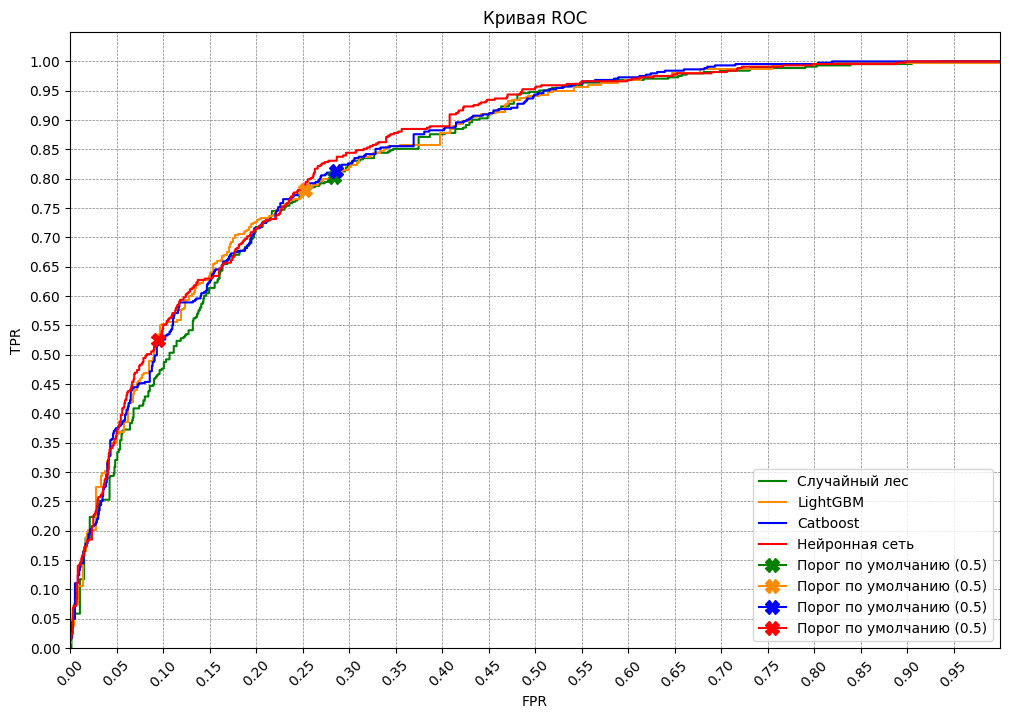

In [102]:
# Построим кривую ROC и отметим точку, соответствующую обученной модели
# Модель на основе случайного леса
probabilities_forest = gs_rf.predict_proba(test[X])
probabilities_one_forest = probabilities_forest[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test[y], probabilities_one_forest)
# Модель из библиотеки LightGBM
probabilities_lgbm = grid_lgbm.predict_proba(X_test_LGBM)
probabilities_one_lgbm = probabilities_lgbm[:, 1]
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(test[y], probabilities_one_lgbm)
# Модель из библитоки catboost
probabilities_cb = grid_cb.predict_proba(X_test_cb)
probabilities_one_cb = probabilities_cb[:, 1]
fpr_cb, tpr_cb, thresholds_cb = roc_curve(test[y], probabilities_one_cb)
# Нейронная сеть
probabilities_net = gs_net_3.best_estimator_.predict_proba(test[X])
probabilities_one_net = probabilities_net[:, 1]
fpr_net, tpr_net, thresholds_net = roc_curve(test[y], probabilities_one_net)

# Кривые ROC
plt.figure(figsize=(12, 8))
plt.step(fpr_rf, tpr_rf, where='post', label='Случайный лес', color='green')
plt.step(fpr_lgbm, tpr_lgbm, where='post', label='LightGBM', color='darkorange')
plt.step(fpr_cb, tpr_cb, where='post', label='Catboost', color='blue')
plt.step(fpr_net, tpr_net, where='post', label='Нейронная сеть', color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.xticks(np.arange(0, 1.0, step=0.05), rotation=45)
plt.yticks(np.arange(0, 1.05, step=0.05))
plt.grid(color='gray', linewidth=0.5, linestyle='--')
plt.title('Кривая ROC')
# Точки обученных моделей на кривой
# Модель на основе случайного леса
plt.plot(
    fpr_rf[thresholds_rf == thresholds_rf[thresholds_rf >= 0.5][-1]],
    tpr_rf[thresholds_rf == thresholds_rf[thresholds_rf >= 0.5][-1]],
    color='green',
    marker='X',
    markersize=10,
    label='Порог по умолчанию (0.5)'
)
# Модель из библиотеки LightGBM
plt.plot(
    fpr_lgbm[thresholds_lgbm == thresholds_lgbm[thresholds_lgbm >= 0.5][-1]],
    tpr_lgbm[thresholds_lgbm == thresholds_lgbm[thresholds_lgbm >= 0.5][-1]],
    color='darkorange',
    marker='X',
    markersize=10,
    label='Порог по умолчанию (0.5)'
)
# Модель из библитоки catboost
plt.plot(
    fpr_cb[thresholds_cb == thresholds_cb[thresholds_cb >= 0.5][-1]],
    tpr_cb[thresholds_cb == thresholds_cb[thresholds_cb >= 0.5][-1]],
    color='blue',
    marker='X',
    markersize=10,
    label='Порог по умолчанию (0.5)'
)

# Нейронная сеть
plt.plot(
    fpr_net[thresholds_net == thresholds_net[thresholds_net >= 0.5][-1]],
    tpr_net[thresholds_net == thresholds_net[thresholds_net >= 0.5][-1]],
    color='red',
    marker='X',
    markersize=10,
    label='Порог по умолчанию (0.5)'
)
# plt.plot(fpr[thresholds==thresholds[tpr>=0.7][0]],
#    tpr[thresholds==thresholds[tpr>=0.7][0]], color='green', marker='o', markersize=8, label='Изменённый порог')
plt.legend()
plt.show()

По результатам обучения выбираем модель на основе полносвязной нейронной сети.

## Тестирование модели

In [103]:
# Подберём порог таким образом, чтоб точка на ROC была ближе всего к точке TPR=1 и FPR=0
min_distance = 2**0.5
best_tpr = 0
best_fpr = 1
best_th = 0
for th in np.arange(0,1,0.0001):
    tpr = tpr_net[thresholds_net == thresholds_net[thresholds_net >= th][-1]]
    fpr = fpr_net[thresholds_net == thresholds_net[thresholds_net >= th][-1]]
    distance = ((1 - tpr)**2 + fpr**2)**0.5
    if distance < min_distance:
        best_th = th
        best_tpr = tpr
        best_fpr = fpr
        min_distance = distance
print(f'best_th {best_th} best_tpr {best_tpr} best_fpr {best_fpr}')

best_th 0.2617 best_tpr [0.82167043] best_fpr [0.26631259]


In [106]:
# Проверим метрики наилучшей модели на тестовой выборке
roc_auc = roc_auc_score(test[y], probabilities_one_net)
print(f'test_auc_roc: {roc_auc: .2f}')

test_predicted = (probabilities_one_net>best_th).astype('int')

accuracy = accuracy_score(test[y], test_predicted)
print(f'test_accuracy: {accuracy: .2f}')

test_auc_roc:  0.85
test_accuracy:  0.75


Удалось достичь значение метрики AUC ROC 0,85. Рассмотрим матрицу ошибок.

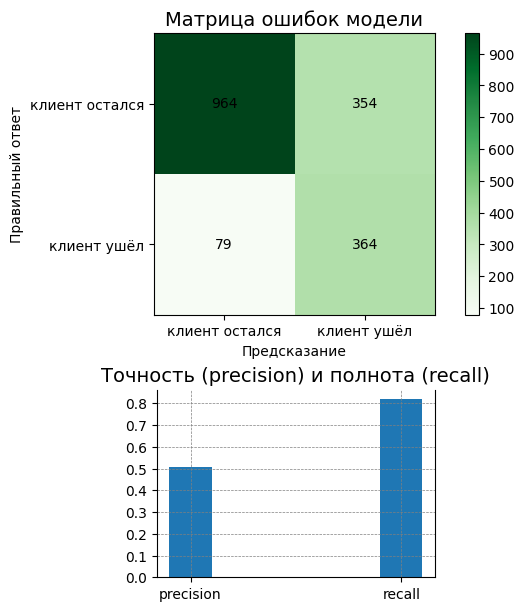

In [107]:
fig = plt.figure(figsize=(8, 6),
                       constrained_layout=True)
gs = fig.add_gridspec(5, 5)
f_ax1 = fig.add_subplot(gs[:3,:4])
f_ax2 = fig.add_subplot(gs[3:, 2:4])
f_ax1.set_title('Матрица ошибок модели', fontsize=14)
f_ax2.set_title('Точность (precision) и полнота (recall)', fontsize=14)

# Отобразим результаты модели
cm = confusion_matrix(test[y], test_predicted)
f_ax2.grid(color='gray', linewidth = 0.5, linestyle = '--')
f_ax2.set_yticks(np.arange(0, 1, 0.1))
xlabs = ['клиент остался', 'клиент ушёл']
ylabs = xlabs
f_ax1.set_yticks(np.arange(len(ylabs)), labels = ylabs)
f_ax1.set_xticks(np.arange(len(xlabs)), labels = xlabs)
f_ax1.set_ylabel('Правильный ответ')
f_ax1.set_xlabel('Предсказание')
precision = cm[1, 1]/sum(cm[:, 1])
recall = cm[1, 1]/sum(cm[1, :])
for i in range(len(xlabs)):
    for j in range(len(ylabs)):
        text = f_ax1.text(j, i, cm[i, j],
        ha = "center", va = "center", color = "black")
im = f_ax1.imshow(cm, cmap = 'Greens')
cbar = f_ax1.figure.colorbar(im, ax = f_ax1, use_gridspec=True)
f_ax2.spines['top'].set_visible(False)
f_ax2.set_xticks([0, 1], labels = ['precision','recall'])
f_ax2.bar([0, 1], [precision, recall], align='center', width=0.2)
plt.show()

Видим, что модель приблизительно в половине случаев ошибается, тем не менее, 80% отточных клиентов ей удаётся распознать. Считаем такой результат приемлемым. Проанализируем важность признаков

In [108]:
best_net = gs_net_3.best_estimator_.steps[2][1].module_

In [109]:
try:
    feature_names = list(
        col_transformer_net.named_transformers_['onehotencoder'].get_feature_names_out()
    ) + list(
        col_transformer_net.named_transformers_['minmaxscaler'].get_feature_names_out()
    )
except:
    feature_names = list(
        col_transformer_net.transformers_[0][1].get_feature_names()
    ) + list(
        num_features
    )
feature_names

['SeniorCitizen_Yes',
 'Partner_Yes',
 'Dependents_Yes',
 'Type_One year',
 'Type_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_Yes',
 'OnlineBackup_Yes',
 'DeviceProtection_Yes',
 'TechSupport_Yes',
 'StreamingTV_Yes',
 'StreamingMovies_Yes',
 'MultipleLines_Yes',
 'total_charges_cat_clients_1000-3000',
 'total_charges_cat_clients_3000-4000',
 'total_charges_cat_clients_4000',
 'contract_duration_cat_clients_30-80',
 'contract_duration_cat_clients_450-540',
 'contract_duration_cat_clients_540',
 'contract_duration_cat_clients_80-450',
 'MonthlyCharges']

In [110]:
# Просуммируем веса для входов нейронной сети
feature_names = list(
    col_transformer_net.named_transformers_['onehotencoder'].get_feature_names_out()
) + list(
    col_transformer_net.named_transformers_['minmaxscaler'].get_feature_names_out()
)
weight_sum = pd.Series(best_net.fc1.weight.sum(axis=0).cpu().detach().numpy(),
                       index = feature_names)
weight_sum = weight_sum.sort_values()
weight_sum

InternetService_Fiber optic             -2.109434
TechSupport_Yes                          0.364627
PaperlessBilling_Yes                     0.402893
PaymentMethod_Mailed check               0.420384
contract_duration_cat_clients_450-540    0.455401
StreamingTV_Yes                          0.537909
SeniorCitizen_Yes                        0.622062
PaymentMethod_Electronic check           0.657883
contract_duration_cat_clients_30-80      0.885372
DeviceProtection_Yes                     0.944385
MultipleLines_Yes                        0.950705
StreamingMovies_Yes                      1.115822
OnlineBackup_Yes                         1.246349
MonthlyCharges                           1.284143
contract_duration_cat_clients_540        1.463020
Partner_Yes                              2.064137
PaymentMethod_Credit card (automatic)    2.068570
InternetService_No                       2.241148
OnlineSecurity_Yes                       2.496670
Type_One year                            2.497075


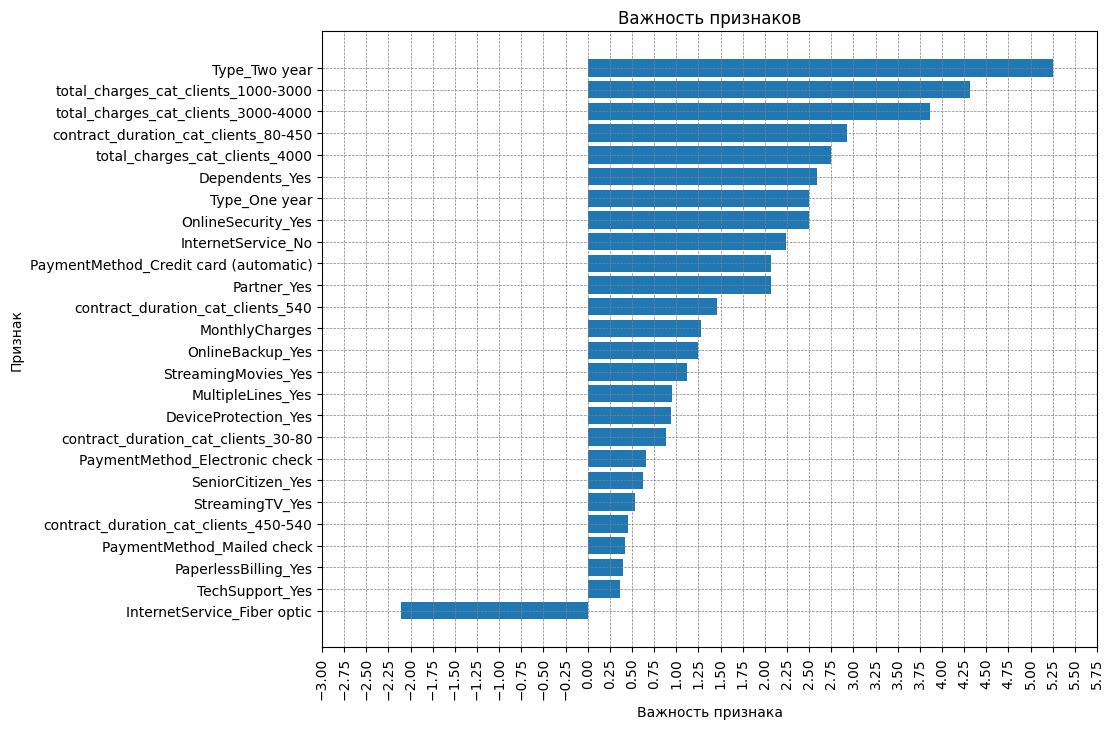

In [115]:
# Построим график
plt.figure(figsize=(10, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.xlim([-0.6, 3])
plt.xticks(np.arange(-3, 6, step=0.25), rotation=90)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=weight_sum.index, width=weight_sum)
plt.show()

In [112]:
# Просуммируем веса для исходных наименований признаков
importances = pd.Series(np.zeros(len(train[X].columns)), index=train[X].columns)

In [113]:
# Теперь сложим веса с учётом исходных наименований признаков до кодировки
for feature in train[X].columns:
    for net_input in weight_sum.index:
        if feature in net_input:
            importances[feature] += weight_sum[net_input]
importances = importances.sort_values()
importances

InternetService           0.131714
TechSupport               0.364627
PaperlessBilling          0.402893
StreamingTV               0.537909
SeniorCitizen             0.622062
DeviceProtection          0.944385
MultipleLines             0.950705
StreamingMovies           1.115822
OnlineBackup              1.246349
MonthlyCharges            1.284143
Partner                   2.064137
OnlineSecurity            2.496670
Dependents                2.591921
PaymentMethod             3.146838
contract_duration_cat     5.729905
Type                      7.750929
total_charges_cat        10.922388
dtype: float64

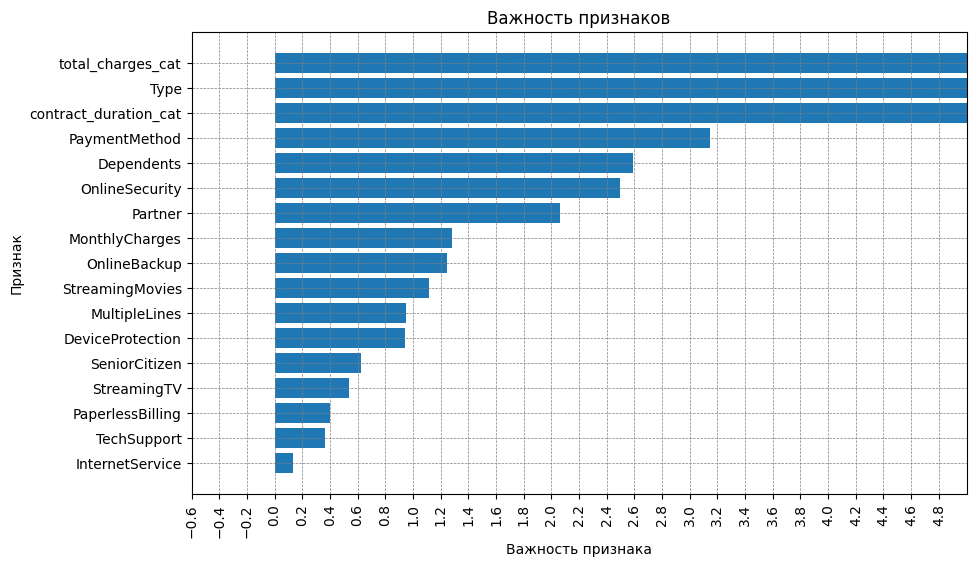

In [114]:
# Построим график
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.xlim([-0.6, 5])
plt.xticks(np.arange(-0.6, 5, step=0.2), rotation=90)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

Наиболее "важные" признаки:
- `total_charges_cat` — категория клиента по общим расходам;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `contract_duration_cat` - категория клиента в зависимости от длительности контракта;
- `PaymentMethod` - тип платежа;
- `Dependents` - наличие или отсутствие детей.

По графикам, полученным в разделе [3.3](#Анализ-данных-объединённой-таблицы), доля ушедших клинентов при различных значениях указанных признаков меняется, т.е. противоречий в полученных результатах не наблюдается. При этом признаки в верхней части таблицы `Type_Two year`, `total_charges_cat_clients_1000-3000`, `total_charges_cat_clients_3000-4000`,
`total_charges_cat_clients_80-450`,
`total_charges_cat_clients_4000` соответствуют больше лояльным клиентам, которые вероятнее всего не уйдут.

## Выводы

В ходе работы выполнено:
- подключение к базе данных и первичный анализ таблиц,
- анализ данных в таблицах,
- объединение таблиц, анализ и предобработка признаков в объединённой таблице,
- выбор факторов для моделей машинного обучения,
- проработка нескольких моделей (на основе случайного леса, модели градиентного бустинга из библиотек LightGBM и Catboost, полносвязная нейронная сеть) выбрана лучшая,
- лучшая модель протестирована,
- проведён анализ важности признаков.  
Рекомендации заказчику: с точки зрения оттока следует обрать внимание на клиентов, у которых оплата помесячно, суммарные затраты меньше 1000, длительность контракта не превышает 90 дней или превышает 540 дней.